In [1]:
# Parameters
patient = 3
device = "cpu"


In [2]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

In [3]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 3    on device: cpu


In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+50)


train_dataset = torch.utils.data.Subset(dataset, range(0, train_size+50))
val_dataset   = torch.utils.data.Subset(dataset, range(train_size+50, train_size+50 + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+50 + val_size, train_size + val_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


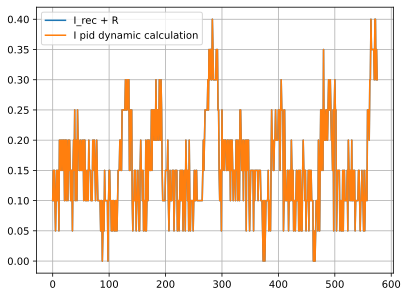

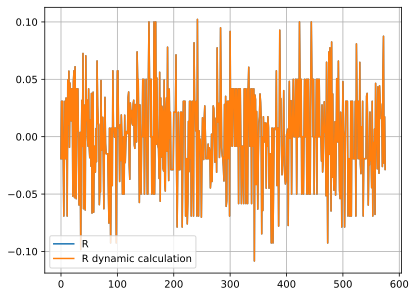

In [5]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


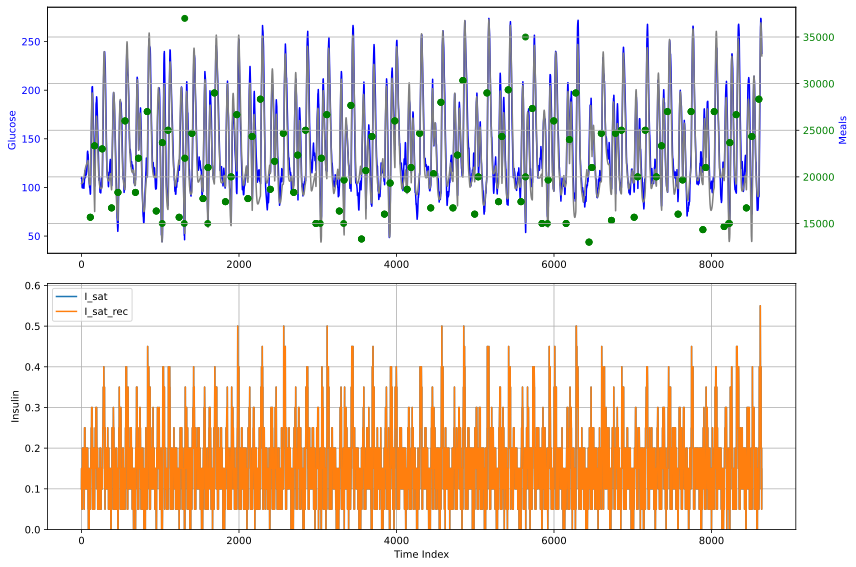

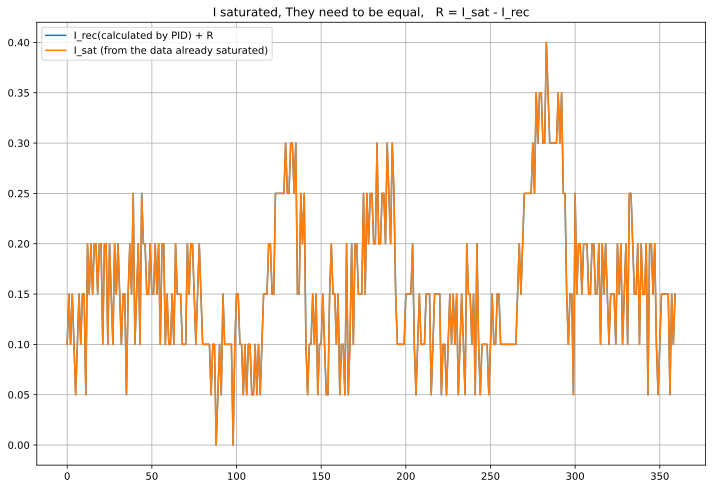

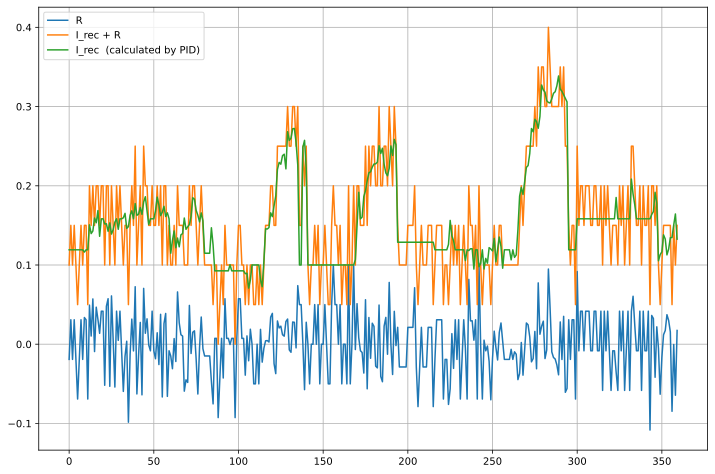

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


In [7]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\Rens.py:313: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  self.x = torch.linalg.lstsq(self.C2, y_init.squeeze(1).T)[0].T.unsqueeze(0).unsqueeze(0)


In [8]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.046719 	||	 Validation Loss: 0.043089


Epoch: 2 	||	 Training Loss: 0.044562 	||	 Validation Loss: 0.041046


Epoch: 3 	||	 Training Loss: 0.042518 	||	 Validation Loss: 0.039123


Epoch: 4 	||	 Training Loss: 0.040592 	||	 Validation Loss: 0.037328


Epoch: 5 	||	 Training Loss: 0.038792 	||	 Validation Loss: 0.035665


Epoch: 6 	||	 Training Loss: 0.037125 	||	 Validation Loss: 0.034142


Epoch: 7 	||	 Training Loss: 0.035594 	||	 Validation Loss: 0.032760


Epoch: 8 	||	 Training Loss: 0.034205 	||	 Validation Loss: 0.031524


Epoch: 9 	||	 Training Loss: 0.032960 	||	 Validation Loss: 0.030433


Epoch: 10 	||	 Training Loss: 0.031859 	||	 Validation Loss: 0.029488


Epoch: 11 	||	 Training Loss: 0.030902 	||	 Validation Loss: 0.028684


Epoch: 12 	||	 Training Loss: 0.030085 	||	 Validation Loss: 0.028018


Epoch: 13 	||	 Training Loss: 0.029406 	||	 Validation Loss: 0.027481


Epoch: 14 	||	 Training Loss: 0.028854 	||	 Validation Loss: 0.027063


Epoch: 15 	||	 Training Loss: 0.028422 	||	 Validation Loss: 0.026753


Epoch: 16 	||	 Training Loss: 0.028097 	||	 Validation Loss: 0.026537


Epoch: 17 	||	 Training Loss: 0.027866 	||	 Validation Loss: 0.026398


Epoch: 18 	||	 Training Loss: 0.027712 	||	 Validation Loss: 0.026320


Epoch: 19 	||	 Training Loss: 0.027620 	||	 Validation Loss: 0.026287


Epoch: 20 	||	 Training Loss: 0.027573 	||	 Validation Loss: 0.026281


Epoch: 21 	||	 Training Loss: 0.027554 	||	 Validation Loss: 0.026289


Epoch: 22 	||	 Training Loss: 0.027550 	||	 Validation Loss: 0.026298


Epoch: 23 	||	 Training Loss: 0.027547 	||	 Validation Loss: 0.026296


Epoch: 24 	||	 Training Loss: 0.027535 	||	 Validation Loss: 0.026278


Epoch: 25 	||	 Training Loss: 0.027507 	||	 Validation Loss: 0.026238


Epoch: 26 	||	 Training Loss: 0.027458 	||	 Validation Loss: 0.026174


Epoch: 27 	||	 Training Loss: 0.027387 	||	 Validation Loss: 0.026087


Epoch: 28 	||	 Training Loss: 0.027293 	||	 Validation Loss: 0.025980


Epoch: 29 	||	 Training Loss: 0.027180 	||	 Validation Loss: 0.025856


Epoch: 30 	||	 Training Loss: 0.027051 	||	 Validation Loss: 0.025721


Epoch: 31 	||	 Training Loss: 0.026911 	||	 Validation Loss: 0.025580


Epoch: 32 	||	 Training Loss: 0.026765 	||	 Validation Loss: 0.025437


Epoch: 33 	||	 Training Loss: 0.026619 	||	 Validation Loss: 0.025299


Epoch: 34 	||	 Training Loss: 0.026477 	||	 Validation Loss: 0.025168


Epoch: 35 	||	 Training Loss: 0.026344 	||	 Validation Loss: 0.025049


Epoch: 36 	||	 Training Loss: 0.026222 	||	 Validation Loss: 0.024943


Epoch: 37 	||	 Training Loss: 0.026113 	||	 Validation Loss: 0.024852


Epoch: 38 	||	 Training Loss: 0.026020 	||	 Validation Loss: 0.024775


Epoch: 39 	||	 Training Loss: 0.025940 	||	 Validation Loss: 0.024710


Epoch: 40 	||	 Training Loss: 0.025873 	||	 Validation Loss: 0.024656


Epoch: 41 	||	 Training Loss: 0.025817 	||	 Validation Loss: 0.024610


Epoch: 42 	||	 Training Loss: 0.025769 	||	 Validation Loss: 0.024568


Epoch: 43 	||	 Training Loss: 0.025725 	||	 Validation Loss: 0.024527


Epoch: 44 	||	 Training Loss: 0.025682 	||	 Validation Loss: 0.024484


Epoch: 45 	||	 Training Loss: 0.025638 	||	 Validation Loss: 0.024438


Epoch: 46 	||	 Training Loss: 0.025590 	||	 Validation Loss: 0.024385


Epoch: 47 	||	 Training Loss: 0.025536 	||	 Validation Loss: 0.024326


Epoch: 48 	||	 Training Loss: 0.025475 	||	 Validation Loss: 0.024260


Epoch: 49 	||	 Training Loss: 0.025408 	||	 Validation Loss: 0.024188


Epoch: 50 	||	 Training Loss: 0.025336 	||	 Validation Loss: 0.024112


Epoch: 51 	||	 Training Loss: 0.025259 	||	 Validation Loss: 0.024033


Epoch: 52 	||	 Training Loss: 0.025180 	||	 Validation Loss: 0.023953


Epoch: 53 	||	 Training Loss: 0.025099 	||	 Validation Loss: 0.023873


Epoch: 54 	||	 Training Loss: 0.025020 	||	 Validation Loss: 0.023794


Epoch: 55 	||	 Training Loss: 0.024942 	||	 Validation Loss: 0.023718


Epoch: 56 	||	 Training Loss: 0.024867 	||	 Validation Loss: 0.023645


Epoch: 57 	||	 Training Loss: 0.024795 	||	 Validation Loss: 0.023574


Epoch: 58 	||	 Training Loss: 0.024725 	||	 Validation Loss: 0.023505


Epoch: 59 	||	 Training Loss: 0.024658 	||	 Validation Loss: 0.023436


Epoch: 60 	||	 Training Loss: 0.024591 	||	 Validation Loss: 0.023367


Epoch: 61 	||	 Training Loss: 0.024525 	||	 Validation Loss: 0.023298


Epoch: 62 	||	 Training Loss: 0.024458 	||	 Validation Loss: 0.023226


Epoch: 63 	||	 Training Loss: 0.024389 	||	 Validation Loss: 0.023153


Epoch: 64 	||	 Training Loss: 0.024318 	||	 Validation Loss: 0.023077


Epoch: 65 	||	 Training Loss: 0.024246 	||	 Validation Loss: 0.022999


Epoch: 66 	||	 Training Loss: 0.024171 	||	 Validation Loss: 0.022920


Epoch: 67 	||	 Training Loss: 0.024095 	||	 Validation Loss: 0.022840


Epoch: 68 	||	 Training Loss: 0.024018 	||	 Validation Loss: 0.022759


Epoch: 69 	||	 Training Loss: 0.023941 	||	 Validation Loss: 0.022679


Epoch: 70 	||	 Training Loss: 0.023864 	||	 Validation Loss: 0.022599


Epoch: 71 	||	 Training Loss: 0.023787 	||	 Validation Loss: 0.022520


Epoch: 72 	||	 Training Loss: 0.023712 	||	 Validation Loss: 0.022441


Epoch: 73 	||	 Training Loss: 0.023636 	||	 Validation Loss: 0.022361


Epoch: 74 	||	 Training Loss: 0.023561 	||	 Validation Loss: 0.022281


Epoch: 75 	||	 Training Loss: 0.023484 	||	 Validation Loss: 0.022198


Epoch: 76 	||	 Training Loss: 0.023406 	||	 Validation Loss: 0.022114


Epoch: 77 	||	 Training Loss: 0.023326 	||	 Validation Loss: 0.022027


Epoch: 78 	||	 Training Loss: 0.023245 	||	 Validation Loss: 0.021937


Epoch: 79 	||	 Training Loss: 0.023161 	||	 Validation Loss: 0.021846


Epoch: 80 	||	 Training Loss: 0.023076 	||	 Validation Loss: 0.021753


Epoch: 81 	||	 Training Loss: 0.022989 	||	 Validation Loss: 0.021660


Epoch: 82 	||	 Training Loss: 0.022902 	||	 Validation Loss: 0.021565


Epoch: 83 	||	 Training Loss: 0.022815 	||	 Validation Loss: 0.021470


Epoch: 84 	||	 Training Loss: 0.022727 	||	 Validation Loss: 0.021374


Epoch: 85 	||	 Training Loss: 0.022638 	||	 Validation Loss: 0.021277


Epoch: 86 	||	 Training Loss: 0.022548 	||	 Validation Loss: 0.021179


Epoch: 87 	||	 Training Loss: 0.022456 	||	 Validation Loss: 0.021080


Epoch: 88 	||	 Training Loss: 0.022363 	||	 Validation Loss: 0.020979


Epoch: 89 	||	 Training Loss: 0.022269 	||	 Validation Loss: 0.020877


Epoch: 90 	||	 Training Loss: 0.022173 	||	 Validation Loss: 0.020774


Epoch: 91 	||	 Training Loss: 0.022076 	||	 Validation Loss: 0.020670


Epoch: 92 	||	 Training Loss: 0.021978 	||	 Validation Loss: 0.020566


Epoch: 93 	||	 Training Loss: 0.021879 	||	 Validation Loss: 0.020460


Epoch: 94 	||	 Training Loss: 0.021779 	||	 Validation Loss: 0.020353


Epoch: 95 	||	 Training Loss: 0.021677 	||	 Validation Loss: 0.020243


Epoch: 96 	||	 Training Loss: 0.021574 	||	 Validation Loss: 0.020132


Epoch: 97 	||	 Training Loss: 0.021468 	||	 Validation Loss: 0.020017


Epoch: 98 	||	 Training Loss: 0.021361 	||	 Validation Loss: 0.019901


Epoch: 99 	||	 Training Loss: 0.021252 	||	 Validation Loss: 0.019784


Epoch: 100 	||	 Training Loss: 0.021142 	||	 Validation Loss: 0.019665


Epoch: 101 	||	 Training Loss: 0.021031 	||	 Validation Loss: 0.019546


Epoch: 102 	||	 Training Loss: 0.020918 	||	 Validation Loss: 0.019425


Epoch: 103 	||	 Training Loss: 0.020803 	||	 Validation Loss: 0.019303


Epoch: 104 	||	 Training Loss: 0.020687 	||	 Validation Loss: 0.019180


Epoch: 105 	||	 Training Loss: 0.020568 	||	 Validation Loss: 0.019056


Epoch: 106 	||	 Training Loss: 0.020448 	||	 Validation Loss: 0.018931


Epoch: 107 	||	 Training Loss: 0.020327 	||	 Validation Loss: 0.018804


Epoch: 108 	||	 Training Loss: 0.020203 	||	 Validation Loss: 0.018675


Epoch: 109 	||	 Training Loss: 0.020078 	||	 Validation Loss: 0.018543


Epoch: 110 	||	 Training Loss: 0.019951 	||	 Validation Loss: 0.018408


Epoch: 111 	||	 Training Loss: 0.019821 	||	 Validation Loss: 0.018272


Epoch: 112 	||	 Training Loss: 0.019690 	||	 Validation Loss: 0.018134


Epoch: 113 	||	 Training Loss: 0.019557 	||	 Validation Loss: 0.017995


Epoch: 114 	||	 Training Loss: 0.019422 	||	 Validation Loss: 0.017856


Epoch: 115 	||	 Training Loss: 0.019285 	||	 Validation Loss: 0.017716


Epoch: 116 	||	 Training Loss: 0.019146 	||	 Validation Loss: 0.017575


Epoch: 117 	||	 Training Loss: 0.019005 	||	 Validation Loss: 0.017432


Epoch: 118 	||	 Training Loss: 0.018862 	||	 Validation Loss: 0.017287


Epoch: 119 	||	 Training Loss: 0.018717 	||	 Validation Loss: 0.017139


Epoch: 120 	||	 Training Loss: 0.018571 	||	 Validation Loss: 0.016988


Epoch: 121 	||	 Training Loss: 0.018422 	||	 Validation Loss: 0.016837


Epoch: 122 	||	 Training Loss: 0.018271 	||	 Validation Loss: 0.016685


Epoch: 123 	||	 Training Loss: 0.018119 	||	 Validation Loss: 0.016533


Epoch: 124 	||	 Training Loss: 0.017965 	||	 Validation Loss: 0.016381


Epoch: 125 	||	 Training Loss: 0.017809 	||	 Validation Loss: 0.016227


Epoch: 126 	||	 Training Loss: 0.017652 	||	 Validation Loss: 0.016072


Epoch: 127 	||	 Training Loss: 0.017493 	||	 Validation Loss: 0.015913


Epoch: 128 	||	 Training Loss: 0.017333 	||	 Validation Loss: 0.015754


Epoch: 129 	||	 Training Loss: 0.017171 	||	 Validation Loss: 0.015595


Epoch: 130 	||	 Training Loss: 0.017009 	||	 Validation Loss: 0.015438


Epoch: 131 	||	 Training Loss: 0.016845 	||	 Validation Loss: 0.015281


Epoch: 132 	||	 Training Loss: 0.016680 	||	 Validation Loss: 0.015123


Epoch: 133 	||	 Training Loss: 0.016515 	||	 Validation Loss: 0.014963


Epoch: 134 	||	 Training Loss: 0.016350 	||	 Validation Loss: 0.014802


Epoch: 135 	||	 Training Loss: 0.016184 	||	 Validation Loss: 0.014645


Epoch: 136 	||	 Training Loss: 0.016018 	||	 Validation Loss: 0.014491


Epoch: 137 	||	 Training Loss: 0.015852 	||	 Validation Loss: 0.014336


Epoch: 138 	||	 Training Loss: 0.015688 	||	 Validation Loss: 0.014180


Epoch: 139 	||	 Training Loss: 0.015524 	||	 Validation Loss: 0.014026


Epoch: 140 	||	 Training Loss: 0.015361 	||	 Validation Loss: 0.013877


Epoch: 141 	||	 Training Loss: 0.015200 	||	 Validation Loss: 0.013732


Epoch: 142 	||	 Training Loss: 0.015040 	||	 Validation Loss: 0.013585


Epoch: 143 	||	 Training Loss: 0.014883 	||	 Validation Loss: 0.013441


Epoch: 144 	||	 Training Loss: 0.014729 	||	 Validation Loss: 0.013305


Epoch: 145 	||	 Training Loss: 0.014577 	||	 Validation Loss: 0.013172


Epoch: 146 	||	 Training Loss: 0.014429 	||	 Validation Loss: 0.013039


Epoch: 147 	||	 Training Loss: 0.014285 	||	 Validation Loss: 0.012914


Epoch: 148 	||	 Training Loss: 0.014144 	||	 Validation Loss: 0.012795


Epoch: 149 	||	 Training Loss: 0.014008 	||	 Validation Loss: 0.012675


Epoch: 150 	||	 Training Loss: 0.013877 	||	 Validation Loss: 0.012567


Epoch: 151 	||	 Training Loss: 0.013751 	||	 Validation Loss: 0.012461


Epoch: 152 	||	 Training Loss: 0.013630 	||	 Validation Loss: 0.012359


Epoch: 153 	||	 Training Loss: 0.013514 	||	 Validation Loss: 0.012270


Epoch: 154 	||	 Training Loss: 0.013405 	||	 Validation Loss: 0.012173


Epoch: 155 	||	 Training Loss: 0.013300 	||	 Validation Loss: 0.012108


Epoch: 156 	||	 Training Loss: 0.013203 	||	 Validation Loss: 0.011997


Epoch: 157 	||	 Training Loss: 0.013114 	||	 Validation Loss: 0.012050


Epoch: 158 	||	 Training Loss: 0.013057 	||	 Validation Loss: 0.011886


Epoch: 159 	||	 Training Loss: 0.013099 	||	 Validation Loss: 0.012216


Epoch: 160 	||	 Training Loss: 0.013094 	||	 Validation Loss: 0.011748


Epoch: 161 	||	 Training Loss: 0.012849 	||	 Validation Loss: 0.011713


Epoch: 162 	||	 Training Loss: 0.012852 	||	 Validation Loss: 0.011978


Epoch: 163 	||	 Training Loss: 0.012856 	||	 Validation Loss: 0.011662


Epoch: 164 	||	 Training Loss: 0.012677 	||	 Validation Loss: 0.011614


Epoch: 165 	||	 Training Loss: 0.012739 	||	 Validation Loss: 0.011755


Epoch: 166 	||	 Training Loss: 0.012653 	||	 Validation Loss: 0.011643


Epoch: 167 	||	 Training Loss: 0.012577 	||	 Validation Loss: 0.011526


Epoch: 168 	||	 Training Loss: 0.012622 	||	 Validation Loss: 0.011580


Epoch: 169 	||	 Training Loss: 0.012507 	||	 Validation Loss: 0.011627


Epoch: 170 	||	 Training Loss: 0.012510 	||	 Validation Loss: 0.011446


Epoch: 171 	||	 Training Loss: 0.012504 	||	 Validation Loss: 0.011464


Epoch: 172 	||	 Training Loss: 0.012412 	||	 Validation Loss: 0.011581


Epoch: 173 	||	 Training Loss: 0.012440 	||	 Validation Loss: 0.011380


Epoch: 174 	||	 Training Loss: 0.012404 	||	 Validation Loss: 0.011386


Epoch: 175 	||	 Training Loss: 0.012342 	||	 Validation Loss: 0.011516


Epoch: 176 	||	 Training Loss: 0.012368 	||	 Validation Loss: 0.011326


Epoch: 177 	||	 Training Loss: 0.012325 	||	 Validation Loss: 0.011327


Epoch: 178 	||	 Training Loss: 0.012281 	||	 Validation Loss: 0.011446


Epoch: 179 	||	 Training Loss: 0.012300 	||	 Validation Loss: 0.011277


Epoch: 180 	||	 Training Loss: 0.012262 	||	 Validation Loss: 0.011282


Epoch: 181 	||	 Training Loss: 0.012227 	||	 Validation Loss: 0.011379


Epoch: 182 	||	 Training Loss: 0.012239 	||	 Validation Loss: 0.011232


Epoch: 183 	||	 Training Loss: 0.012213 	||	 Validation Loss: 0.011248


Epoch: 184 	||	 Training Loss: 0.012178 	||	 Validation Loss: 0.011313


Epoch: 185 	||	 Training Loss: 0.012184 	||	 Validation Loss: 0.011191


Epoch: 186 	||	 Training Loss: 0.012171 	||	 Validation Loss: 0.011226


Epoch: 187 	||	 Training Loss: 0.012139 	||	 Validation Loss: 0.011247


Epoch: 188 	||	 Training Loss: 0.012135 	||	 Validation Loss: 0.011155


Epoch: 189 	||	 Training Loss: 0.012134 	||	 Validation Loss: 0.011214


Epoch: 190 	||	 Training Loss: 0.012109 	||	 Validation Loss: 0.011182


Epoch: 191 	||	 Training Loss: 0.012093 	||	 Validation Loss: 0.011127


Epoch: 192 	||	 Training Loss: 0.012095 	||	 Validation Loss: 0.011201


Epoch: 193 	||	 Training Loss: 0.012084 	||	 Validation Loss: 0.011127


Epoch: 194 	||	 Training Loss: 0.012064 	||	 Validation Loss: 0.011113


Epoch: 195 	||	 Training Loss: 0.012057 	||	 Validation Loss: 0.011171


Epoch: 196 	||	 Training Loss: 0.012055 	||	 Validation Loss: 0.011088


Epoch: 197 	||	 Training Loss: 0.012044 	||	 Validation Loss: 0.011116


Epoch: 198 	||	 Training Loss: 0.012029 	||	 Validation Loss: 0.011117


Epoch: 199 	||	 Training Loss: 0.012022 	||	 Validation Loss: 0.011066


Epoch: 200 	||	 Training Loss: 0.012020 	||	 Validation Loss: 0.011121


Epoch: 201 	||	 Training Loss: 0.012011 	||	 Validation Loss: 0.011065


Epoch: 202 	||	 Training Loss: 0.011999 	||	 Validation Loss: 0.011065


Epoch: 203 	||	 Training Loss: 0.011990 	||	 Validation Loss: 0.011091


Epoch: 204 	||	 Training Loss: 0.011986 	||	 Validation Loss: 0.011036


Epoch: 205 	||	 Training Loss: 0.011981 	||	 Validation Loss: 0.011079


Epoch: 206 	||	 Training Loss: 0.011972 	||	 Validation Loss: 0.011039


Epoch: 207 	||	 Training Loss: 0.011962 	||	 Validation Loss: 0.011036


Epoch: 208 	||	 Training Loss: 0.011955 	||	 Validation Loss: 0.011056


Epoch: 209 	||	 Training Loss: 0.011950 	||	 Validation Loss: 0.011011


Epoch: 210 	||	 Training Loss: 0.011945 	||	 Validation Loss: 0.011050


Epoch: 211 	||	 Training Loss: 0.011937 	||	 Validation Loss: 0.011007


Epoch: 212 	||	 Training Loss: 0.011929 	||	 Validation Loss: 0.011019


Epoch: 213 	||	 Training Loss: 0.011921 	||	 Validation Loss: 0.011016


Epoch: 214 	||	 Training Loss: 0.011914 	||	 Validation Loss: 0.010992


Epoch: 215 	||	 Training Loss: 0.011908 	||	 Validation Loss: 0.011019


Epoch: 216 	||	 Training Loss: 0.011902 	||	 Validation Loss: 0.010977


Epoch: 217 	||	 Training Loss: 0.011896 	||	 Validation Loss: 0.011008


Epoch: 218 	||	 Training Loss: 0.011888 	||	 Validation Loss: 0.010970


Epoch: 219 	||	 Training Loss: 0.011880 	||	 Validation Loss: 0.010986


Epoch: 220 	||	 Training Loss: 0.011872 	||	 Validation Loss: 0.010968


Epoch: 221 	||	 Training Loss: 0.011865 	||	 Validation Loss: 0.010963


Epoch: 222 	||	 Training Loss: 0.011857 	||	 Validation Loss: 0.010966


Epoch: 223 	||	 Training Loss: 0.011850 	||	 Validation Loss: 0.010943


Epoch: 224 	||	 Training Loss: 0.011843 	||	 Validation Loss: 0.010962


Epoch: 225 	||	 Training Loss: 0.011836 	||	 Validation Loss: 0.010925


Epoch: 226 	||	 Training Loss: 0.011828 	||	 Validation Loss: 0.010955


Epoch: 227 	||	 Training Loss: 0.011821 	||	 Validation Loss: 0.010907


Epoch: 228 	||	 Training Loss: 0.011814 	||	 Validation Loss: 0.010949


Epoch: 229 	||	 Training Loss: 0.011806 	||	 Validation Loss: 0.010886


Epoch: 230 	||	 Training Loss: 0.011799 	||	 Validation Loss: 0.010948


Epoch: 231 	||	 Training Loss: 0.011793 	||	 Validation Loss: 0.010864


Epoch: 232 	||	 Training Loss: 0.011788 	||	 Validation Loss: 0.010955


Epoch: 233 	||	 Training Loss: 0.011784 	||	 Validation Loss: 0.010842


Epoch: 234 	||	 Training Loss: 0.011782 	||	 Validation Loss: 0.010970


Epoch: 235 	||	 Training Loss: 0.011781 	||	 Validation Loss: 0.010822


Epoch: 236 	||	 Training Loss: 0.011776 	||	 Validation Loss: 0.010962


Epoch: 237 	||	 Training Loss: 0.011766 	||	 Validation Loss: 0.010800


Epoch: 238 	||	 Training Loss: 0.011744 	||	 Validation Loss: 0.010886


Epoch: 239 	||	 Training Loss: 0.011717 	||	 Validation Loss: 0.010793


Epoch: 240 	||	 Training Loss: 0.011692 	||	 Validation Loss: 0.010793


Epoch: 241 	||	 Training Loss: 0.011676 	||	 Validation Loss: 0.010820


Epoch: 242 	||	 Training Loss: 0.011669 	||	 Validation Loss: 0.010742


Epoch: 243 	||	 Training Loss: 0.011664 	||	 Validation Loss: 0.010826


Epoch: 244 	||	 Training Loss: 0.011655 	||	 Validation Loss: 0.010712


Epoch: 245 	||	 Training Loss: 0.011636 	||	 Validation Loss: 0.010766


Epoch: 246 	||	 Training Loss: 0.011613 	||	 Validation Loss: 0.010697


Epoch: 247 	||	 Training Loss: 0.011590 	||	 Validation Loss: 0.010685


Epoch: 248 	||	 Training Loss: 0.011572 	||	 Validation Loss: 0.010700


Epoch: 249 	||	 Training Loss: 0.011558 	||	 Validation Loss: 0.010628


Epoch: 250 	||	 Training Loss: 0.011544 	||	 Validation Loss: 0.010677


Epoch: 251 	||	 Training Loss: 0.011525 	||	 Validation Loss: 0.010588


Epoch: 252 	||	 Training Loss: 0.011502 	||	 Validation Loss: 0.010606


Epoch: 253 	||	 Training Loss: 0.011476 	||	 Validation Loss: 0.010562


Epoch: 254 	||	 Training Loss: 0.011451 	||	 Validation Loss: 0.010527


Epoch: 255 	||	 Training Loss: 0.011429 	||	 Validation Loss: 0.010537


Epoch: 256 	||	 Training Loss: 0.011407 	||	 Validation Loss: 0.010464


Epoch: 257 	||	 Training Loss: 0.011382 	||	 Validation Loss: 0.010479


Epoch: 258 	||	 Training Loss: 0.011354 	||	 Validation Loss: 0.010412


Epoch: 259 	||	 Training Loss: 0.011323 	||	 Validation Loss: 0.010393


Epoch: 260 	||	 Training Loss: 0.011293 	||	 Validation Loss: 0.010367


Epoch: 261 	||	 Training Loss: 0.011263 	||	 Validation Loss: 0.010309


Epoch: 262 	||	 Training Loss: 0.011232 	||	 Validation Loss: 0.010306


Epoch: 263 	||	 Training Loss: 0.011200 	||	 Validation Loss: 0.010237


Epoch: 264 	||	 Training Loss: 0.011166 	||	 Validation Loss: 0.010217


Epoch: 265 	||	 Training Loss: 0.011130 	||	 Validation Loss: 0.010175


Epoch: 266 	||	 Training Loss: 0.011094 	||	 Validation Loss: 0.010123


Epoch: 267 	||	 Training Loss: 0.011059 	||	 Validation Loss: 0.010105


Epoch: 268 	||	 Training Loss: 0.011023 	||	 Validation Loss: 0.010041


Epoch: 269 	||	 Training Loss: 0.010986 	||	 Validation Loss: 0.010014


Epoch: 270 	||	 Training Loss: 0.010949 	||	 Validation Loss: 0.009973


Epoch: 271 	||	 Training Loss: 0.010912 	||	 Validation Loss: 0.009923


Epoch: 272 	||	 Training Loss: 0.010877 	||	 Validation Loss: 0.009901


Epoch: 273 	||	 Training Loss: 0.010842 	||	 Validation Loss: 0.009850


Epoch: 274 	||	 Training Loss: 0.010807 	||	 Validation Loss: 0.009820


Epoch: 275 	||	 Training Loss: 0.010774 	||	 Validation Loss: 0.009793


Epoch: 276 	||	 Training Loss: 0.010744 	||	 Validation Loss: 0.009751


Epoch: 277 	||	 Training Loss: 0.010714 	||	 Validation Loss: 0.009736


Epoch: 278 	||	 Training Loss: 0.010687 	||	 Validation Loss: 0.009707


Epoch: 279 	||	 Training Loss: 0.010661 	||	 Validation Loss: 0.009682


Epoch: 280 	||	 Training Loss: 0.010638 	||	 Validation Loss: 0.009675


Epoch: 281 	||	 Training Loss: 0.010616 	||	 Validation Loss: 0.009652


Epoch: 282 	||	 Training Loss: 0.010596 	||	 Validation Loss: 0.009643


Epoch: 283 	||	 Training Loss: 0.010578 	||	 Validation Loss: 0.009641


Epoch: 284 	||	 Training Loss: 0.010562 	||	 Validation Loss: 0.009628


Epoch: 285 	||	 Training Loss: 0.010547 	||	 Validation Loss: 0.009631


Epoch: 286 	||	 Training Loss: 0.010533 	||	 Validation Loss: 0.009632


Epoch: 287 	||	 Training Loss: 0.010520 	||	 Validation Loss: 0.009628


Epoch: 288 	||	 Training Loss: 0.010508 	||	 Validation Loss: 0.009638


Epoch: 289 	||	 Training Loss: 0.010497 	||	 Validation Loss: 0.009641


Epoch: 290 	||	 Training Loss: 0.010486 	||	 Validation Loss: 0.009644


Epoch: 291 	||	 Training Loss: 0.010476 	||	 Validation Loss: 0.009657


Epoch: 292 	||	 Training Loss: 0.010466 	||	 Validation Loss: 0.009661


Epoch: 293 	||	 Training Loss: 0.010458 	||	 Validation Loss: 0.009670


Epoch: 294 	||	 Training Loss: 0.010450 	||	 Validation Loss: 0.009684


Epoch: 295 	||	 Training Loss: 0.010442 	||	 Validation Loss: 0.009689


Epoch: 296 	||	 Training Loss: 0.010436 	||	 Validation Loss: 0.009702


Epoch: 297 	||	 Training Loss: 0.010430 	||	 Validation Loss: 0.009714


Epoch: 298 	||	 Training Loss: 0.010425 	||	 Validation Loss: 0.009720


Epoch: 299 	||	 Training Loss: 0.010421 	||	 Validation Loss: 0.009735


Epoch: 300 	||	 Training Loss: 0.010417 	||	 Validation Loss: 0.009742


Epoch: 301 	||	 Training Loss: 0.010414 	||	 Validation Loss: 0.009751


Epoch: 302 	||	 Training Loss: 0.010412 	||	 Validation Loss: 0.009762


Epoch: 303 	||	 Training Loss: 0.010409 	||	 Validation Loss: 0.009766


Epoch: 304 	||	 Training Loss: 0.010407 	||	 Validation Loss: 0.009775


Epoch: 305 	||	 Training Loss: 0.010405 	||	 Validation Loss: 0.009780


Epoch: 306 	||	 Training Loss: 0.010403 	||	 Validation Loss: 0.009783


Epoch: 307 	||	 Training Loss: 0.010401 	||	 Validation Loss: 0.009789


Epoch: 308 	||	 Training Loss: 0.010399 	||	 Validation Loss: 0.009789


Epoch: 309 	||	 Training Loss: 0.010397 	||	 Validation Loss: 0.009791


Epoch: 310 	||	 Training Loss: 0.010395 	||	 Validation Loss: 0.009793


Epoch: 311 	||	 Training Loss: 0.010393 	||	 Validation Loss: 0.009791


Epoch: 312 	||	 Training Loss: 0.010391 	||	 Validation Loss: 0.009792


Epoch: 313 	||	 Training Loss: 0.010389 	||	 Validation Loss: 0.009789


Epoch: 314 	||	 Training Loss: 0.010387 	||	 Validation Loss: 0.009788


Epoch: 315 	||	 Training Loss: 0.010385 	||	 Validation Loss: 0.009787


Epoch: 316 	||	 Training Loss: 0.010382 	||	 Validation Loss: 0.009783


Epoch: 317 	||	 Training Loss: 0.010380 	||	 Validation Loss: 0.009782


Epoch: 318 	||	 Training Loss: 0.010378 	||	 Validation Loss: 0.009778


Epoch: 319 	||	 Training Loss: 0.010376 	||	 Validation Loss: 0.009775


Epoch: 320 	||	 Training Loss: 0.010374 	||	 Validation Loss: 0.009772


Epoch: 321 	||	 Training Loss: 0.010372 	||	 Validation Loss: 0.009768


Epoch: 322 	||	 Training Loss: 0.010369 	||	 Validation Loss: 0.009766


Epoch: 323 	||	 Training Loss: 0.010367 	||	 Validation Loss: 0.009761


Epoch: 324 	||	 Training Loss: 0.010365 	||	 Validation Loss: 0.009758


Epoch: 325 	||	 Training Loss: 0.010362 	||	 Validation Loss: 0.009755


Epoch: 326 	||	 Training Loss: 0.010360 	||	 Validation Loss: 0.009750


Epoch: 327 	||	 Training Loss: 0.010358 	||	 Validation Loss: 0.009748


Epoch: 328 	||	 Training Loss: 0.010355 	||	 Validation Loss: 0.009743


Epoch: 329 	||	 Training Loss: 0.010353 	||	 Validation Loss: 0.009740


Epoch: 330 	||	 Training Loss: 0.010351 	||	 Validation Loss: 0.009736


Epoch: 331 	||	 Training Loss: 0.010349 	||	 Validation Loss: 0.009733


Epoch: 332 	||	 Training Loss: 0.010346 	||	 Validation Loss: 0.009730


Epoch: 333 	||	 Training Loss: 0.010344 	||	 Validation Loss: 0.009725


Epoch: 334 	||	 Training Loss: 0.010342 	||	 Validation Loss: 0.009723


Epoch: 335 	||	 Training Loss: 0.010340 	||	 Validation Loss: 0.009718


Epoch: 336 	||	 Training Loss: 0.010338 	||	 Validation Loss: 0.009715


Epoch: 337 	||	 Training Loss: 0.010336 	||	 Validation Loss: 0.009712


Epoch: 338 	||	 Training Loss: 0.010334 	||	 Validation Loss: 0.009708


Epoch: 339 	||	 Training Loss: 0.010332 	||	 Validation Loss: 0.009705


Epoch: 340 	||	 Training Loss: 0.010330 	||	 Validation Loss: 0.009701


Epoch: 341 	||	 Training Loss: 0.010328 	||	 Validation Loss: 0.009699


Epoch: 342 	||	 Training Loss: 0.010326 	||	 Validation Loss: 0.009695


Epoch: 343 	||	 Training Loss: 0.010324 	||	 Validation Loss: 0.009692


Epoch: 344 	||	 Training Loss: 0.010322 	||	 Validation Loss: 0.009689


Epoch: 345 	||	 Training Loss: 0.010320 	||	 Validation Loss: 0.009686


Epoch: 346 	||	 Training Loss: 0.010318 	||	 Validation Loss: 0.009683


Epoch: 347 	||	 Training Loss: 0.010316 	||	 Validation Loss: 0.009680


Epoch: 348 	||	 Training Loss: 0.010314 	||	 Validation Loss: 0.009678


Epoch: 349 	||	 Training Loss: 0.010312 	||	 Validation Loss: 0.009675


Epoch: 350 	||	 Training Loss: 0.010310 	||	 Validation Loss: 0.009673


Epoch: 351 	||	 Training Loss: 0.010308 	||	 Validation Loss: 0.009671


Epoch: 352 	||	 Training Loss: 0.010306 	||	 Validation Loss: 0.009669


Epoch: 353 	||	 Training Loss: 0.010304 	||	 Validation Loss: 0.009667


Epoch: 354 	||	 Training Loss: 0.010302 	||	 Validation Loss: 0.009665


Epoch: 355 	||	 Training Loss: 0.010300 	||	 Validation Loss: 0.009663


Epoch: 356 	||	 Training Loss: 0.010298 	||	 Validation Loss: 0.009661


Epoch: 357 	||	 Training Loss: 0.010296 	||	 Validation Loss: 0.009660


Epoch: 358 	||	 Training Loss: 0.010295 	||	 Validation Loss: 0.009658


Epoch: 359 	||	 Training Loss: 0.010293 	||	 Validation Loss: 0.009656


Epoch: 360 	||	 Training Loss: 0.010291 	||	 Validation Loss: 0.009655


Epoch: 361 	||	 Training Loss: 0.010289 	||	 Validation Loss: 0.009653


Epoch: 362 	||	 Training Loss: 0.010287 	||	 Validation Loss: 0.009653


Epoch: 363 	||	 Training Loss: 0.010285 	||	 Validation Loss: 0.009650


Epoch: 364 	||	 Training Loss: 0.010283 	||	 Validation Loss: 0.009650


Epoch: 365 	||	 Training Loss: 0.010281 	||	 Validation Loss: 0.009647


Epoch: 366 	||	 Training Loss: 0.010280 	||	 Validation Loss: 0.009648


Epoch: 367 	||	 Training Loss: 0.010278 	||	 Validation Loss: 0.009644


Epoch: 368 	||	 Training Loss: 0.010276 	||	 Validation Loss: 0.009645


Epoch: 369 	||	 Training Loss: 0.010274 	||	 Validation Loss: 0.009641


Epoch: 370 	||	 Training Loss: 0.010272 	||	 Validation Loss: 0.009644


Epoch: 371 	||	 Training Loss: 0.010270 	||	 Validation Loss: 0.009637


Epoch: 372 	||	 Training Loss: 0.010268 	||	 Validation Loss: 0.009643


Epoch: 373 	||	 Training Loss: 0.010267 	||	 Validation Loss: 0.009631


Epoch: 374 	||	 Training Loss: 0.010265 	||	 Validation Loss: 0.009646


Epoch: 375 	||	 Training Loss: 0.010263 	||	 Validation Loss: 0.009622


Epoch: 376 	||	 Training Loss: 0.010262 	||	 Validation Loss: 0.009654


Epoch: 377 	||	 Training Loss: 0.010262 	||	 Validation Loss: 0.009608


Epoch: 378 	||	 Training Loss: 0.010262 	||	 Validation Loss: 0.009682


Epoch: 379 	||	 Training Loss: 0.010266 	||	 Validation Loss: 0.009591


Epoch: 380 	||	 Training Loss: 0.010277 	||	 Validation Loss: 0.009764


Epoch: 381 	||	 Training Loss: 0.010302 	||	 Validation Loss: 0.009595


Epoch: 382 	||	 Training Loss: 0.010343 	||	 Validation Loss: 0.009948


Epoch: 383 	||	 Training Loss: 0.010415 	||	 Validation Loss: 0.009626


Epoch: 384 	||	 Training Loss: 0.010423 	||	 Validation Loss: 0.009889


Epoch: 385 	||	 Training Loss: 0.010375 	||	 Validation Loss: 0.009581


Epoch: 386 	||	 Training Loss: 0.010263 	||	 Validation Loss: 0.009582


Epoch: 387 	||	 Training Loss: 0.010256 	||	 Validation Loss: 0.009819


Epoch: 388 	||	 Training Loss: 0.010329 	||	 Validation Loss: 0.009579


Epoch: 389 	||	 Training Loss: 0.010323 	||	 Validation Loss: 0.009687


Epoch: 390 	||	 Training Loss: 0.010257 	||	 Validation Loss: 0.009643


Epoch: 391 	||	 Training Loss: 0.010241 	||	 Validation Loss: 0.009567


Epoch: 392 	||	 Training Loss: 0.010286 	||	 Validation Loss: 0.009756


Epoch: 393 	||	 Training Loss: 0.010289 	||	 Validation Loss: 0.009576


Epoch: 394 	||	 Training Loss: 0.010238 	||	 Validation Loss: 0.009571


Epoch: 395 	||	 Training Loss: 0.010240 	||	 Validation Loss: 0.009730


Epoch: 396 	||	 Training Loss: 0.010272 	||	 Validation Loss: 0.009561


Epoch: 397 	||	 Training Loss: 0.010251 	||	 Validation Loss: 0.009602


Epoch: 398 	||	 Training Loss: 0.010223 	||	 Validation Loss: 0.009664


Epoch: 399 	||	 Training Loss: 0.010238 	||	 Validation Loss: 0.009556


Epoch: 400 	||	 Training Loss: 0.010247 	||	 Validation Loss: 0.009639


Epoch: 401 	||	 Training Loss: 0.010227 	||	 Validation Loss: 0.009607


Epoch: 402 	||	 Training Loss: 0.010217 	||	 Validation Loss: 0.009555


Epoch: 403 	||	 Training Loss: 0.010231 	||	 Validation Loss: 0.009658


Epoch: 404 	||	 Training Loss: 0.010230 	||	 Validation Loss: 0.009572


Epoch: 405 	||	 Training Loss: 0.010212 	||	 Validation Loss: 0.009563


Epoch: 406 	||	 Training Loss: 0.010213 	||	 Validation Loss: 0.009646


Epoch: 407 	||	 Training Loss: 0.010222 	||	 Validation Loss: 0.009555


Epoch: 408 	||	 Training Loss: 0.010213 	||	 Validation Loss: 0.009580


Epoch: 409 	||	 Training Loss: 0.010203 	||	 Validation Loss: 0.009615


Epoch: 410 	||	 Training Loss: 0.010207 	||	 Validation Loss: 0.009547


Epoch: 411 	||	 Training Loss: 0.010209 	||	 Validation Loss: 0.009598


Epoch: 412 	||	 Training Loss: 0.010200 	||	 Validation Loss: 0.009581


Epoch: 413 	||	 Training Loss: 0.010195 	||	 Validation Loss: 0.009546


Epoch: 414 	||	 Training Loss: 0.010198 	||	 Validation Loss: 0.009604


Epoch: 415 	||	 Training Loss: 0.010197 	||	 Validation Loss: 0.009555


Epoch: 416 	||	 Training Loss: 0.010190 	||	 Validation Loss: 0.009552


Epoch: 417 	||	 Training Loss: 0.010187 	||	 Validation Loss: 0.009592


Epoch: 418 	||	 Training Loss: 0.010189 	||	 Validation Loss: 0.009540


Epoch: 419 	||	 Training Loss: 0.010185 	||	 Validation Loss: 0.009562


Epoch: 420 	||	 Training Loss: 0.010180 	||	 Validation Loss: 0.009569


Epoch: 421 	||	 Training Loss: 0.010178 	||	 Validation Loss: 0.009533


Epoch: 422 	||	 Training Loss: 0.010178 	||	 Validation Loss: 0.009568


Epoch: 423 	||	 Training Loss: 0.010174 	||	 Validation Loss: 0.009545


Epoch: 424 	||	 Training Loss: 0.010169 	||	 Validation Loss: 0.009533


Epoch: 425 	||	 Training Loss: 0.010168 	||	 Validation Loss: 0.009562


Epoch: 426 	||	 Training Loss: 0.010166 	||	 Validation Loss: 0.009527


Epoch: 427 	||	 Training Loss: 0.010162 	||	 Validation Loss: 0.009536


Epoch: 428 	||	 Training Loss: 0.010158 	||	 Validation Loss: 0.009545


Epoch: 429 	||	 Training Loss: 0.010156 	||	 Validation Loss: 0.009516


Epoch: 430 	||	 Training Loss: 0.010153 	||	 Validation Loss: 0.009538


Epoch: 431 	||	 Training Loss: 0.010149 	||	 Validation Loss: 0.009523


Epoch: 432 	||	 Training Loss: 0.010145 	||	 Validation Loss: 0.009512


Epoch: 433 	||	 Training Loss: 0.010141 	||	 Validation Loss: 0.009529


Epoch: 434 	||	 Training Loss: 0.010138 	||	 Validation Loss: 0.009503


Epoch: 435 	||	 Training Loss: 0.010134 	||	 Validation Loss: 0.009509


Epoch: 436 	||	 Training Loss: 0.010129 	||	 Validation Loss: 0.009510


Epoch: 437 	||	 Training Loss: 0.010125 	||	 Validation Loss: 0.009490


Epoch: 438 	||	 Training Loss: 0.010120 	||	 Validation Loss: 0.009503


Epoch: 439 	||	 Training Loss: 0.010115 	||	 Validation Loss: 0.009486


Epoch: 440 	||	 Training Loss: 0.010109 	||	 Validation Loss: 0.009479


Epoch: 441 	||	 Training Loss: 0.010104 	||	 Validation Loss: 0.009485


Epoch: 442 	||	 Training Loss: 0.010098 	||	 Validation Loss: 0.009463


Epoch: 443 	||	 Training Loss: 0.010092 	||	 Validation Loss: 0.009467


Epoch: 444 	||	 Training Loss: 0.010085 	||	 Validation Loss: 0.009457


Epoch: 445 	||	 Training Loss: 0.010077 	||	 Validation Loss: 0.009442


Epoch: 446 	||	 Training Loss: 0.010070 	||	 Validation Loss: 0.009445


Epoch: 447 	||	 Training Loss: 0.010061 	||	 Validation Loss: 0.009425


Epoch: 448 	||	 Training Loss: 0.010052 	||	 Validation Loss: 0.009419


Epoch: 449 	||	 Training Loss: 0.010042 	||	 Validation Loss: 0.009410


Epoch: 450 	||	 Training Loss: 0.010031 	||	 Validation Loss: 0.009389


Epoch: 451 	||	 Training Loss: 0.010019 	||	 Validation Loss: 0.009384


Epoch: 452 	||	 Training Loss: 0.010006 	||	 Validation Loss: 0.009362


Epoch: 453 	||	 Training Loss: 0.009992 	||	 Validation Loss: 0.009346


Epoch: 454 	||	 Training Loss: 0.009976 	||	 Validation Loss: 0.009331


Epoch: 455 	||	 Training Loss: 0.009959 	||	 Validation Loss: 0.009302


Epoch: 456 	||	 Training Loss: 0.009940 	||	 Validation Loss: 0.009286


Epoch: 457 	||	 Training Loss: 0.009919 	||	 Validation Loss: 0.009256


Epoch: 458 	||	 Training Loss: 0.009896 	||	 Validation Loss: 0.009226


Epoch: 459 	||	 Training Loss: 0.009870 	||	 Validation Loss: 0.009197


Epoch: 460 	||	 Training Loss: 0.009841 	||	 Validation Loss: 0.009154


Epoch: 461 	||	 Training Loss: 0.009808 	||	 Validation Loss: 0.009117


Epoch: 462 	||	 Training Loss: 0.009771 	||	 Validation Loss: 0.009068


Epoch: 463 	||	 Training Loss: 0.009729 	||	 Validation Loss: 0.009014


Epoch: 464 	||	 Training Loss: 0.009681 	||	 Validation Loss: 0.008958


Epoch: 465 	||	 Training Loss: 0.009626 	||	 Validation Loss: 0.008887


Epoch: 466 	||	 Training Loss: 0.009562 	||	 Validation Loss: 0.008815


Epoch: 467 	||	 Training Loss: 0.009490 	||	 Validation Loss: 0.008731


Epoch: 468 	||	 Training Loss: 0.009408 	||	 Validation Loss: 0.008639


Epoch: 469 	||	 Training Loss: 0.009315 	||	 Validation Loss: 0.008546


Epoch: 470 	||	 Training Loss: 0.009213 	||	 Validation Loss: 0.008444


Epoch: 471 	||	 Training Loss: 0.009104 	||	 Validation Loss: 0.008352


Epoch: 472 	||	 Training Loss: 0.008993 	||	 Validation Loss: 0.008266


Epoch: 473 	||	 Training Loss: 0.008886 	||	 Validation Loss: 0.008200


Epoch: 474 	||	 Training Loss: 0.008791 	||	 Validation Loss: 0.008161


Epoch: 475 	||	 Training Loss: 0.008713 	||	 Validation Loss: 0.008145


Epoch: 476 	||	 Training Loss: 0.008657 	||	 Validation Loss: 0.008159


Epoch: 477 	||	 Training Loss: 0.008621 	||	 Validation Loss: 0.008188


Epoch: 478 	||	 Training Loss: 0.008601 	||	 Validation Loss: 0.008230


Epoch: 479 	||	 Training Loss: 0.008591 	||	 Validation Loss: 0.008276


Epoch: 480 	||	 Training Loss: 0.008587 	||	 Validation Loss: 0.008317


Epoch: 481 	||	 Training Loss: 0.008584 	||	 Validation Loss: 0.008354


Epoch: 482 	||	 Training Loss: 0.008580 	||	 Validation Loss: 0.008376


Epoch: 483 	||	 Training Loss: 0.008572 	||	 Validation Loss: 0.008390


Epoch: 484 	||	 Training Loss: 0.008560 	||	 Validation Loss: 0.008388


Epoch: 485 	||	 Training Loss: 0.008543 	||	 Validation Loss: 0.008374


Epoch: 486 	||	 Training Loss: 0.008522 	||	 Validation Loss: 0.008351


Epoch: 487 	||	 Training Loss: 0.008499 	||	 Validation Loss: 0.008320


Epoch: 488 	||	 Training Loss: 0.008474 	||	 Validation Loss: 0.008292


Epoch: 489 	||	 Training Loss: 0.008452 	||	 Validation Loss: 0.008266


Epoch: 490 	||	 Training Loss: 0.008435 	||	 Validation Loss: 0.008256


Epoch: 491 	||	 Training Loss: 0.008422 	||	 Validation Loss: 0.008249


Epoch: 492 	||	 Training Loss: 0.008413 	||	 Validation Loss: 0.008260


Epoch: 493 	||	 Training Loss: 0.008407 	||	 Validation Loss: 0.008261


Epoch: 494 	||	 Training Loss: 0.008403 	||	 Validation Loss: 0.008285


Epoch: 495 	||	 Training Loss: 0.008400 	||	 Validation Loss: 0.008268


Epoch: 496 	||	 Training Loss: 0.008396 	||	 Validation Loss: 0.008303


Epoch: 497 	||	 Training Loss: 0.008391 	||	 Validation Loss: 0.008245


Epoch: 498 	||	 Training Loss: 0.008386 	||	 Validation Loss: 0.008335


Epoch: 499 	||	 Training Loss: 0.008389 	||	 Validation Loss: 0.008223


Epoch: 500 	||	 Training Loss: 0.008406 	||	 Validation Loss: 0.008463


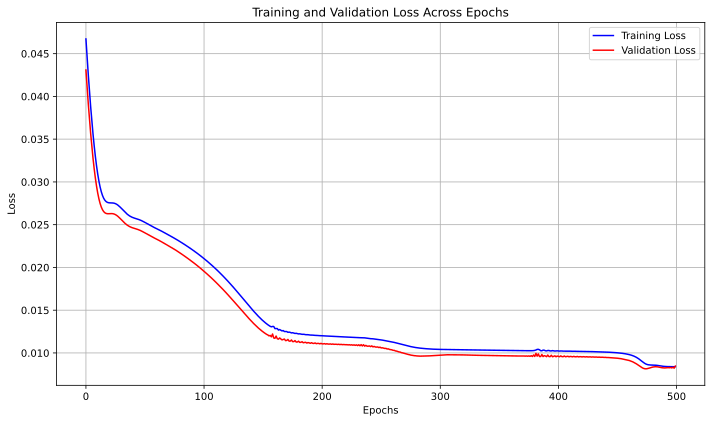

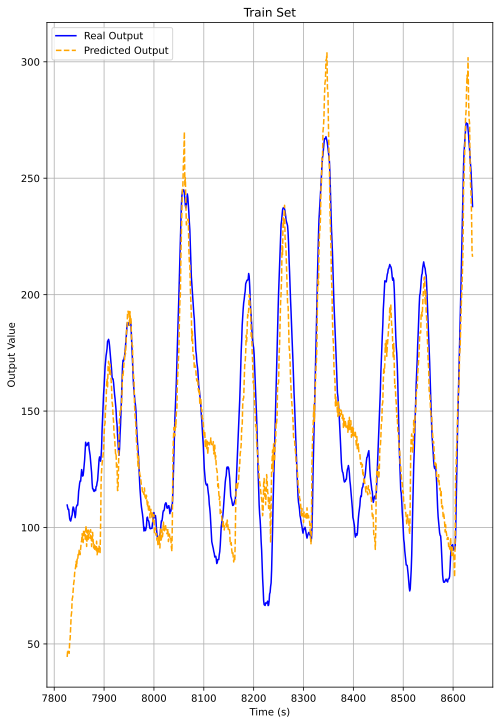

In [9]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [11]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

[INFO] Training on device: cpu


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\env_non_lin_sys_id\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch: 1 	||	 Training Loss: 0.315229 	||	 Validation Loss: 0.307668


Epoch: 2 	||	 Training Loss: 0.311927 	||	 Validation Loss: 0.303059


Epoch: 3 	||	 Training Loss: 0.307199 	||	 Validation Loss: 0.301242


Epoch: 4 	||	 Training Loss: 0.302227 	||	 Validation Loss: 0.297265


Epoch: 5 	||	 Training Loss: 0.297057 	||	 Validation Loss: 0.296049


Epoch: 6 	||	 Training Loss: 0.293148 	||	 Validation Loss: 0.290271


Epoch: 7 	||	 Training Loss: 0.288197 	||	 Validation Loss: 0.285991


Epoch: 8 	||	 Training Loss: 0.283256 	||	 Validation Loss: 0.279764


Epoch: 9 	||	 Training Loss: 0.278547 	||	 Validation Loss: 0.273290


Epoch: 10 	||	 Training Loss: 0.275755 	||	 Validation Loss: 0.272099


Epoch: 11 	||	 Training Loss: 0.270115 	||	 Validation Loss: 0.264996


Epoch: 12 	||	 Training Loss: 0.267051 	||	 Validation Loss: 0.262713


Epoch: 13 	||	 Training Loss: 0.261305 	||	 Validation Loss: 0.250498


Epoch: 14 	||	 Training Loss: 0.255426 	||	 Validation Loss: 0.252083


Epoch: 15 	||	 Training Loss: 0.251036 	||	 Validation Loss: 0.244237


Epoch: 16 	||	 Training Loss: 0.245979 	||	 Validation Loss: 0.241237


Epoch: 17 	||	 Training Loss: 0.240850 	||	 Validation Loss: 0.235738


Epoch: 18 	||	 Training Loss: 0.237078 	||	 Validation Loss: 0.234078


Epoch: 19 	||	 Training Loss: 0.232538 	||	 Validation Loss: 0.221626


Epoch: 20 	||	 Training Loss: 0.226003 	||	 Validation Loss: 0.217414


Epoch: 21 	||	 Training Loss: 0.220918 	||	 Validation Loss: 0.216260


Epoch: 22 	||	 Training Loss: 0.216497 	||	 Validation Loss: 0.202299


Epoch: 23 	||	 Training Loss: 0.208720 	||	 Validation Loss: 0.197286


Epoch: 24 	||	 Training Loss: 0.203256 	||	 Validation Loss: 0.194014


Epoch: 25 	||	 Training Loss: 0.196038 	||	 Validation Loss: 0.179135


Epoch: 26 	||	 Training Loss: 0.190467 	||	 Validation Loss: 0.183698


Epoch: 27 	||	 Training Loss: 0.181241 	||	 Validation Loss: 0.170503


Epoch: 28 	||	 Training Loss: 0.175760 	||	 Validation Loss: 0.162659


Epoch: 29 	||	 Training Loss: 0.166802 	||	 Validation Loss: 0.157642


Epoch: 30 	||	 Training Loss: 0.157474 	||	 Validation Loss: 0.146800


Epoch: 31 	||	 Training Loss: 0.147600 	||	 Validation Loss: 0.136536


Epoch: 32 	||	 Training Loss: 0.139773 	||	 Validation Loss: 0.127364


Epoch: 33 	||	 Training Loss: 0.130591 	||	 Validation Loss: 0.120876


Epoch: 34 	||	 Training Loss: 0.123440 	||	 Validation Loss: 0.110682


Epoch: 35 	||	 Training Loss: 0.116051 	||	 Validation Loss: 0.104475


Epoch: 36 	||	 Training Loss: 0.106503 	||	 Validation Loss: 0.095290


Epoch: 37 	||	 Training Loss: 0.098767 	||	 Validation Loss: 0.089869


Epoch: 38 	||	 Training Loss: 0.092324 	||	 Validation Loss: 0.083902


Epoch: 39 	||	 Training Loss: 0.086223 	||	 Validation Loss: 0.077781


Epoch: 40 	||	 Training Loss: 0.079740 	||	 Validation Loss: 0.072447


Epoch: 41 	||	 Training Loss: 0.074061 	||	 Validation Loss: 0.068026


Epoch: 42 	||	 Training Loss: 0.068829 	||	 Validation Loss: 0.064092


Epoch: 43 	||	 Training Loss: 0.064128 	||	 Validation Loss: 0.060180


Epoch: 44 	||	 Training Loss: 0.060217 	||	 Validation Loss: 0.056335


Epoch: 45 	||	 Training Loss: 0.056380 	||	 Validation Loss: 0.053604


Epoch: 46 	||	 Training Loss: 0.052937 	||	 Validation Loss: 0.050842


Epoch: 47 	||	 Training Loss: 0.050025 	||	 Validation Loss: 0.048719


Epoch: 48 	||	 Training Loss: 0.047573 	||	 Validation Loss: 0.046599


Epoch: 49 	||	 Training Loss: 0.045495 	||	 Validation Loss: 0.044701


Epoch: 50 	||	 Training Loss: 0.043617 	||	 Validation Loss: 0.043275


Epoch: 51 	||	 Training Loss: 0.042060 	||	 Validation Loss: 0.042033


Epoch: 52 	||	 Training Loss: 0.040721 	||	 Validation Loss: 0.041212


Epoch: 53 	||	 Training Loss: 0.039633 	||	 Validation Loss: 0.040415


Epoch: 54 	||	 Training Loss: 0.038914 	||	 Validation Loss: 0.039569


Epoch: 55 	||	 Training Loss: 0.038375 	||	 Validation Loss: 0.039532


Epoch: 56 	||	 Training Loss: 0.037919 	||	 Validation Loss: 0.038695


Epoch: 57 	||	 Training Loss: 0.037709 	||	 Validation Loss: 0.038904


Epoch: 58 	||	 Training Loss: 0.037610 	||	 Validation Loss: 0.039087


Epoch: 59 	||	 Training Loss: 0.037501 	||	 Validation Loss: 0.039084


Epoch: 60 	||	 Training Loss: 0.037650 	||	 Validation Loss: 0.038516


Epoch: 61 	||	 Training Loss: 0.037827 	||	 Validation Loss: 0.038869


Epoch: 62 	||	 Training Loss: 0.037818 	||	 Validation Loss: 0.039150


Epoch: 63 	||	 Training Loss: 0.037892 	||	 Validation Loss: 0.039379


Epoch: 64 	||	 Training Loss: 0.038163 	||	 Validation Loss: 0.039041


Epoch: 65 	||	 Training Loss: 0.037953 	||	 Validation Loss: 0.039230


Epoch: 66 	||	 Training Loss: 0.037903 	||	 Validation Loss: 0.038959


Epoch: 67 	||	 Training Loss: 0.038024 	||	 Validation Loss: 0.038841


Epoch: 68 	||	 Training Loss: 0.037807 	||	 Validation Loss: 0.038849


Epoch: 69 	||	 Training Loss: 0.037619 	||	 Validation Loss: 0.038841


Epoch: 70 	||	 Training Loss: 0.037472 	||	 Validation Loss: 0.038794


Epoch: 71 	||	 Training Loss: 0.037368 	||	 Validation Loss: 0.038400


Epoch: 72 	||	 Training Loss: 0.037059 	||	 Validation Loss: 0.038019


Epoch: 73 	||	 Training Loss: 0.036877 	||	 Validation Loss: 0.038045


Epoch: 74 	||	 Training Loss: 0.036665 	||	 Validation Loss: 0.037851


Epoch: 75 	||	 Training Loss: 0.036431 	||	 Validation Loss: 0.037297


Epoch: 76 	||	 Training Loss: 0.036125 	||	 Validation Loss: 0.037089


Epoch: 77 	||	 Training Loss: 0.035974 	||	 Validation Loss: 0.036650


Epoch: 78 	||	 Training Loss: 0.035716 	||	 Validation Loss: 0.036659


Epoch: 79 	||	 Training Loss: 0.035463 	||	 Validation Loss: 0.036678


Epoch: 80 	||	 Training Loss: 0.035249 	||	 Validation Loss: 0.036376


Epoch: 81 	||	 Training Loss: 0.035229 	||	 Validation Loss: 0.035938


Epoch: 82 	||	 Training Loss: 0.034993 	||	 Validation Loss: 0.036016


Epoch: 83 	||	 Training Loss: 0.034951 	||	 Validation Loss: 0.035815


Epoch: 84 	||	 Training Loss: 0.034830 	||	 Validation Loss: 0.036002


Epoch: 85 	||	 Training Loss: 0.034832 	||	 Validation Loss: 0.035509


Epoch: 86 	||	 Training Loss: 0.034569 	||	 Validation Loss: 0.035719


Epoch: 87 	||	 Training Loss: 0.034485 	||	 Validation Loss: 0.035286


Epoch: 88 	||	 Training Loss: 0.034403 	||	 Validation Loss: 0.035048


Epoch: 89 	||	 Training Loss: 0.034340 	||	 Validation Loss: 0.034863


Epoch: 90 	||	 Training Loss: 0.034170 	||	 Validation Loss: 0.034992


Epoch: 91 	||	 Training Loss: 0.034067 	||	 Validation Loss: 0.034791


Epoch: 92 	||	 Training Loss: 0.033995 	||	 Validation Loss: 0.034466


Epoch: 93 	||	 Training Loss: 0.033955 	||	 Validation Loss: 0.034713


Epoch: 94 	||	 Training Loss: 0.033866 	||	 Validation Loss: 0.034260


Epoch: 95 	||	 Training Loss: 0.033725 	||	 Validation Loss: 0.034166


Epoch: 96 	||	 Training Loss: 0.033542 	||	 Validation Loss: 0.034438


Epoch: 97 	||	 Training Loss: 0.033505 	||	 Validation Loss: 0.034068


Epoch: 98 	||	 Training Loss: 0.033364 	||	 Validation Loss: 0.033890


Epoch: 99 	||	 Training Loss: 0.033303 	||	 Validation Loss: 0.033611


Epoch: 100 	||	 Training Loss: 0.033173 	||	 Validation Loss: 0.033756


Epoch: 101 	||	 Training Loss: 0.033169 	||	 Validation Loss: 0.033458


Epoch: 102 	||	 Training Loss: 0.032961 	||	 Validation Loss: 0.033278


Epoch: 103 	||	 Training Loss: 0.032852 	||	 Validation Loss: 0.033266


Epoch: 104 	||	 Training Loss: 0.032805 	||	 Validation Loss: 0.033269


Epoch: 105 	||	 Training Loss: 0.032715 	||	 Validation Loss: 0.033037


Epoch: 106 	||	 Training Loss: 0.032601 	||	 Validation Loss: 0.033161


Epoch: 107 	||	 Training Loss: 0.032471 	||	 Validation Loss: 0.032904


Epoch: 108 	||	 Training Loss: 0.032313 	||	 Validation Loss: 0.032727


Epoch: 109 	||	 Training Loss: 0.032240 	||	 Validation Loss: 0.032516


Epoch: 110 	||	 Training Loss: 0.032068 	||	 Validation Loss: 0.032275


Epoch: 111 	||	 Training Loss: 0.032094 	||	 Validation Loss: 0.032251


Epoch: 112 	||	 Training Loss: 0.031921 	||	 Validation Loss: 0.032093


Epoch: 113 	||	 Training Loss: 0.031807 	||	 Validation Loss: 0.032108


Epoch: 114 	||	 Training Loss: 0.031676 	||	 Validation Loss: 0.031919


Epoch: 115 	||	 Training Loss: 0.031610 	||	 Validation Loss: 0.031729


Epoch: 116 	||	 Training Loss: 0.031479 	||	 Validation Loss: 0.031466


Epoch: 117 	||	 Training Loss: 0.031392 	||	 Validation Loss: 0.031441


Epoch: 118 	||	 Training Loss: 0.031247 	||	 Validation Loss: 0.031351


Epoch: 119 	||	 Training Loss: 0.031086 	||	 Validation Loss: 0.031228


Epoch: 120 	||	 Training Loss: 0.030932 	||	 Validation Loss: 0.030957


Epoch: 121 	||	 Training Loss: 0.030821 	||	 Validation Loss: 0.030709


Epoch: 122 	||	 Training Loss: 0.030779 	||	 Validation Loss: 0.030631


Epoch: 123 	||	 Training Loss: 0.030624 	||	 Validation Loss: 0.030465


Epoch: 124 	||	 Training Loss: 0.030569 	||	 Validation Loss: 0.030309


Epoch: 125 	||	 Training Loss: 0.030395 	||	 Validation Loss: 0.030276


Epoch: 126 	||	 Training Loss: 0.030266 	||	 Validation Loss: 0.030142


Epoch: 127 	||	 Training Loss: 0.030125 	||	 Validation Loss: 0.029942


Epoch: 128 	||	 Training Loss: 0.030041 	||	 Validation Loss: 0.029590


Epoch: 129 	||	 Training Loss: 0.029896 	||	 Validation Loss: 0.029782


Epoch: 130 	||	 Training Loss: 0.029771 	||	 Validation Loss: 0.029452


Epoch: 131 	||	 Training Loss: 0.029640 	||	 Validation Loss: 0.029515


Epoch: 132 	||	 Training Loss: 0.029454 	||	 Validation Loss: 0.029241


Epoch: 133 	||	 Training Loss: 0.029362 	||	 Validation Loss: 0.028915


Epoch: 134 	||	 Training Loss: 0.029239 	||	 Validation Loss: 0.029038


Epoch: 135 	||	 Training Loss: 0.029193 	||	 Validation Loss: 0.028779


Epoch: 136 	||	 Training Loss: 0.029020 	||	 Validation Loss: 0.028592


Epoch: 137 	||	 Training Loss: 0.028885 	||	 Validation Loss: 0.028643


Epoch: 138 	||	 Training Loss: 0.028744 	||	 Validation Loss: 0.028521


Epoch: 139 	||	 Training Loss: 0.028602 	||	 Validation Loss: 0.028279


Epoch: 140 	||	 Training Loss: 0.028471 	||	 Validation Loss: 0.027967


Epoch: 141 	||	 Training Loss: 0.028370 	||	 Validation Loss: 0.027782


Epoch: 142 	||	 Training Loss: 0.028239 	||	 Validation Loss: 0.027513


Epoch: 143 	||	 Training Loss: 0.028086 	||	 Validation Loss: 0.027745


Epoch: 144 	||	 Training Loss: 0.027966 	||	 Validation Loss: 0.027302


Epoch: 145 	||	 Training Loss: 0.027838 	||	 Validation Loss: 0.027179


Epoch: 146 	||	 Training Loss: 0.027713 	||	 Validation Loss: 0.027007


Epoch: 147 	||	 Training Loss: 0.027595 	||	 Validation Loss: 0.026765


Epoch: 148 	||	 Training Loss: 0.027440 	||	 Validation Loss: 0.026721


Epoch: 149 	||	 Training Loss: 0.027368 	||	 Validation Loss: 0.026574


Epoch: 150 	||	 Training Loss: 0.027152 	||	 Validation Loss: 0.026452


Epoch: 151 	||	 Training Loss: 0.027083 	||	 Validation Loss: 0.026314


Epoch: 152 	||	 Training Loss: 0.026952 	||	 Validation Loss: 0.026158


Epoch: 153 	||	 Training Loss: 0.026846 	||	 Validation Loss: 0.025881


Epoch: 154 	||	 Training Loss: 0.026715 	||	 Validation Loss: 0.025971


Epoch: 155 	||	 Training Loss: 0.026579 	||	 Validation Loss: 0.025711


Epoch: 156 	||	 Training Loss: 0.026465 	||	 Validation Loss: 0.025608


Epoch: 157 	||	 Training Loss: 0.026336 	||	 Validation Loss: 0.025544


Epoch: 158 	||	 Training Loss: 0.026222 	||	 Validation Loss: 0.025230


Epoch: 159 	||	 Training Loss: 0.026081 	||	 Validation Loss: 0.025086


Epoch: 160 	||	 Training Loss: 0.025962 	||	 Validation Loss: 0.024934


Epoch: 161 	||	 Training Loss: 0.025828 	||	 Validation Loss: 0.024832


Epoch: 162 	||	 Training Loss: 0.025709 	||	 Validation Loss: 0.024573


Epoch: 163 	||	 Training Loss: 0.025606 	||	 Validation Loss: 0.024543


Epoch: 164 	||	 Training Loss: 0.025472 	||	 Validation Loss: 0.024420


Epoch: 165 	||	 Training Loss: 0.025376 	||	 Validation Loss: 0.024171


Epoch: 166 	||	 Training Loss: 0.025186 	||	 Validation Loss: 0.024184


Epoch: 167 	||	 Training Loss: 0.025122 	||	 Validation Loss: 0.023849


Epoch: 168 	||	 Training Loss: 0.024974 	||	 Validation Loss: 0.023757


Epoch: 169 	||	 Training Loss: 0.024882 	||	 Validation Loss: 0.023780


Epoch: 170 	||	 Training Loss: 0.024802 	||	 Validation Loss: 0.023561


Epoch: 171 	||	 Training Loss: 0.024587 	||	 Validation Loss: 0.023395


Epoch: 172 	||	 Training Loss: 0.024485 	||	 Validation Loss: 0.023248


Epoch: 173 	||	 Training Loss: 0.024374 	||	 Validation Loss: 0.023141


Epoch: 174 	||	 Training Loss: 0.024287 	||	 Validation Loss: 0.023006


Epoch: 175 	||	 Training Loss: 0.024142 	||	 Validation Loss: 0.022948


Epoch: 176 	||	 Training Loss: 0.024026 	||	 Validation Loss: 0.022609


Epoch: 177 	||	 Training Loss: 0.023924 	||	 Validation Loss: 0.022675


Epoch: 178 	||	 Training Loss: 0.023830 	||	 Validation Loss: 0.022457


Epoch: 179 	||	 Training Loss: 0.023732 	||	 Validation Loss: 0.022345


Epoch: 180 	||	 Training Loss: 0.023613 	||	 Validation Loss: 0.022194


Epoch: 181 	||	 Training Loss: 0.023485 	||	 Validation Loss: 0.022065


Epoch: 182 	||	 Training Loss: 0.023395 	||	 Validation Loss: 0.021879


Epoch: 183 	||	 Training Loss: 0.023297 	||	 Validation Loss: 0.021832


Epoch: 184 	||	 Training Loss: 0.023184 	||	 Validation Loss: 0.021454


Epoch: 185 	||	 Training Loss: 0.023077 	||	 Validation Loss: 0.021398


Epoch: 186 	||	 Training Loss: 0.022996 	||	 Validation Loss: 0.021386


Epoch: 187 	||	 Training Loss: 0.022860 	||	 Validation Loss: 0.021342


Epoch: 188 	||	 Training Loss: 0.022764 	||	 Validation Loss: 0.021111


Epoch: 189 	||	 Training Loss: 0.022680 	||	 Validation Loss: 0.021014


Epoch: 190 	||	 Training Loss: 0.022566 	||	 Validation Loss: 0.020886


Epoch: 191 	||	 Training Loss: 0.022494 	||	 Validation Loss: 0.020831


Epoch: 192 	||	 Training Loss: 0.022359 	||	 Validation Loss: 0.020640


Epoch: 193 	||	 Training Loss: 0.022282 	||	 Validation Loss: 0.020473


Epoch: 194 	||	 Training Loss: 0.022180 	||	 Validation Loss: 0.020387


Epoch: 195 	||	 Training Loss: 0.022071 	||	 Validation Loss: 0.020390


Epoch: 196 	||	 Training Loss: 0.021980 	||	 Validation Loss: 0.020114


Epoch: 197 	||	 Training Loss: 0.021879 	||	 Validation Loss: 0.019985


Epoch: 198 	||	 Training Loss: 0.021803 	||	 Validation Loss: 0.019948


Epoch: 199 	||	 Training Loss: 0.021698 	||	 Validation Loss: 0.019820


Epoch: 200 	||	 Training Loss: 0.021556 	||	 Validation Loss: 0.019836


Epoch: 201 	||	 Training Loss: 0.021445 	||	 Validation Loss: 0.019604


Epoch: 202 	||	 Training Loss: 0.021386 	||	 Validation Loss: 0.019520


Epoch: 203 	||	 Training Loss: 0.021287 	||	 Validation Loss: 0.019391


Epoch: 204 	||	 Training Loss: 0.021192 	||	 Validation Loss: 0.019308


Epoch: 205 	||	 Training Loss: 0.021111 	||	 Validation Loss: 0.019251


Epoch: 206 	||	 Training Loss: 0.020995 	||	 Validation Loss: 0.019106


Epoch: 207 	||	 Training Loss: 0.020896 	||	 Validation Loss: 0.019084


Epoch: 208 	||	 Training Loss: 0.020797 	||	 Validation Loss: 0.018975


Epoch: 209 	||	 Training Loss: 0.020716 	||	 Validation Loss: 0.018822


Epoch: 210 	||	 Training Loss: 0.020603 	||	 Validation Loss: 0.018733


Epoch: 211 	||	 Training Loss: 0.020513 	||	 Validation Loss: 0.018577


Epoch: 212 	||	 Training Loss: 0.020376 	||	 Validation Loss: 0.018512


Epoch: 213 	||	 Training Loss: 0.020307 	||	 Validation Loss: 0.018408


Epoch: 214 	||	 Training Loss: 0.020194 	||	 Validation Loss: 0.018300


Epoch: 215 	||	 Training Loss: 0.020094 	||	 Validation Loss: 0.018220


Epoch: 216 	||	 Training Loss: 0.020006 	||	 Validation Loss: 0.018127


Epoch: 217 	||	 Training Loss: 0.019908 	||	 Validation Loss: 0.017995


Epoch: 218 	||	 Training Loss: 0.019786 	||	 Validation Loss: 0.017908


Epoch: 219 	||	 Training Loss: 0.019682 	||	 Validation Loss: 0.017858


Epoch: 220 	||	 Training Loss: 0.019557 	||	 Validation Loss: 0.017750


Epoch: 221 	||	 Training Loss: 0.019468 	||	 Validation Loss: 0.017698


Epoch: 222 	||	 Training Loss: 0.019387 	||	 Validation Loss: 0.017569


Epoch: 223 	||	 Training Loss: 0.019263 	||	 Validation Loss: 0.017418


Epoch: 224 	||	 Training Loss: 0.019173 	||	 Validation Loss: 0.017345


Epoch: 225 	||	 Training Loss: 0.019036 	||	 Validation Loss: 0.017230


Epoch: 226 	||	 Training Loss: 0.018966 	||	 Validation Loss: 0.017194


Epoch: 227 	||	 Training Loss: 0.018838 	||	 Validation Loss: 0.017094


Epoch: 228 	||	 Training Loss: 0.018744 	||	 Validation Loss: 0.016929


Epoch: 229 	||	 Training Loss: 0.018629 	||	 Validation Loss: 0.016871


Epoch: 230 	||	 Training Loss: 0.018524 	||	 Validation Loss: 0.016807


Epoch: 231 	||	 Training Loss: 0.018421 	||	 Validation Loss: 0.016680


Epoch: 232 	||	 Training Loss: 0.018314 	||	 Validation Loss: 0.016601


Epoch: 233 	||	 Training Loss: 0.018208 	||	 Validation Loss: 0.016506


Epoch: 234 	||	 Training Loss: 0.018090 	||	 Validation Loss: 0.016380


Epoch: 235 	||	 Training Loss: 0.017985 	||	 Validation Loss: 0.016293


Epoch: 236 	||	 Training Loss: 0.017831 	||	 Validation Loss: 0.016224


Epoch: 237 	||	 Training Loss: 0.017741 	||	 Validation Loss: 0.016091


Epoch: 238 	||	 Training Loss: 0.017605 	||	 Validation Loss: 0.016013


Epoch: 239 	||	 Training Loss: 0.017475 	||	 Validation Loss: 0.015978


Epoch: 240 	||	 Training Loss: 0.017364 	||	 Validation Loss: 0.015866


Epoch: 241 	||	 Training Loss: 0.017229 	||	 Validation Loss: 0.015765


Epoch: 242 	||	 Training Loss: 0.017114 	||	 Validation Loss: 0.015691


Epoch: 243 	||	 Training Loss: 0.016954 	||	 Validation Loss: 0.015580


Epoch: 244 	||	 Training Loss: 0.016801 	||	 Validation Loss: 0.015510


Epoch: 245 	||	 Training Loss: 0.016674 	||	 Validation Loss: 0.015471


Epoch: 246 	||	 Training Loss: 0.016552 	||	 Validation Loss: 0.015254


Epoch: 247 	||	 Training Loss: 0.016438 	||	 Validation Loss: 0.015165


Epoch: 248 	||	 Training Loss: 0.016339 	||	 Validation Loss: 0.015100


Epoch: 249 	||	 Training Loss: 0.016167 	||	 Validation Loss: 0.014907


Epoch: 250 	||	 Training Loss: 0.016030 	||	 Validation Loss: 0.014854


Epoch: 251 	||	 Training Loss: 0.015872 	||	 Validation Loss: 0.014796


Epoch: 252 	||	 Training Loss: 0.015625 	||	 Validation Loss: 0.014797


Epoch: 253 	||	 Training Loss: 0.015557 	||	 Validation Loss: 0.014615


Epoch: 254 	||	 Training Loss: 0.015356 	||	 Validation Loss: 0.014549


Epoch: 255 	||	 Training Loss: 0.015246 	||	 Validation Loss: 0.014487


Epoch: 256 	||	 Training Loss: 0.015122 	||	 Validation Loss: 0.014397


Epoch: 257 	||	 Training Loss: 0.014931 	||	 Validation Loss: 0.014260


Epoch: 258 	||	 Training Loss: 0.014756 	||	 Validation Loss: 0.014180


Epoch: 259 	||	 Training Loss: 0.014613 	||	 Validation Loss: 0.013948


Epoch: 260 	||	 Training Loss: 0.014485 	||	 Validation Loss: 0.013938


Epoch: 261 	||	 Training Loss: 0.014234 	||	 Validation Loss: 0.013758


Epoch: 262 	||	 Training Loss: 0.014119 	||	 Validation Loss: 0.013615


Epoch: 263 	||	 Training Loss: 0.013933 	||	 Validation Loss: 0.013444


Epoch: 264 	||	 Training Loss: 0.013785 	||	 Validation Loss: 0.013506


Epoch: 265 	||	 Training Loss: 0.013654 	||	 Validation Loss: 0.013385


Epoch: 266 	||	 Training Loss: 0.013522 	||	 Validation Loss: 0.013136


Epoch: 267 	||	 Training Loss: 0.013250 	||	 Validation Loss: 0.013125


Epoch: 268 	||	 Training Loss: 0.013239 	||	 Validation Loss: 0.012779


Epoch: 269 	||	 Training Loss: 0.013104 	||	 Validation Loss: 0.012869


Epoch: 270 	||	 Training Loss: 0.012911 	||	 Validation Loss: 0.012667


Epoch: 271 	||	 Training Loss: 0.012744 	||	 Validation Loss: 0.012949


Epoch: 272 	||	 Training Loss: 0.012596 	||	 Validation Loss: 0.012825


Epoch: 273 	||	 Training Loss: 0.012372 	||	 Validation Loss: 0.012857


Epoch: 274 	||	 Training Loss: 0.012315 	||	 Validation Loss: 0.012655


Epoch: 275 	||	 Training Loss: 0.012189 	||	 Validation Loss: 0.012508


Epoch: 276 	||	 Training Loss: 0.012145 	||	 Validation Loss: 0.012495


Epoch: 277 	||	 Training Loss: 0.011953 	||	 Validation Loss: 0.012134


Epoch: 278 	||	 Training Loss: 0.011859 	||	 Validation Loss: 0.012189


Epoch: 279 	||	 Training Loss: 0.011710 	||	 Validation Loss: 0.012232


Epoch: 280 	||	 Training Loss: 0.011622 	||	 Validation Loss: 0.012309


Epoch: 281 	||	 Training Loss: 0.011559 	||	 Validation Loss: 0.012209


Epoch: 282 	||	 Training Loss: 0.011571 	||	 Validation Loss: 0.012113


Epoch: 283 	||	 Training Loss: 0.011429 	||	 Validation Loss: 0.012078


Epoch: 284 	||	 Training Loss: 0.011377 	||	 Validation Loss: 0.012307


Epoch: 285 	||	 Training Loss: 0.011245 	||	 Validation Loss: 0.012261


Epoch: 286 	||	 Training Loss: 0.011249 	||	 Validation Loss: 0.011923


Epoch: 287 	||	 Training Loss: 0.011135 	||	 Validation Loss: 0.011976


Epoch: 288 	||	 Training Loss: 0.010989 	||	 Validation Loss: 0.012126


Epoch: 289 	||	 Training Loss: 0.011023 	||	 Validation Loss: 0.011865


Epoch: 290 	||	 Training Loss: 0.010979 	||	 Validation Loss: 0.012020


Epoch: 291 	||	 Training Loss: 0.011055 	||	 Validation Loss: 0.012161


Epoch: 292 	||	 Training Loss: 0.010900 	||	 Validation Loss: 0.012013


Epoch: 293 	||	 Training Loss: 0.011017 	||	 Validation Loss: 0.012020


Epoch: 294 	||	 Training Loss: 0.010858 	||	 Validation Loss: 0.011881


Epoch: 295 	||	 Training Loss: 0.010885 	||	 Validation Loss: 0.011784


Epoch: 296 	||	 Training Loss: 0.010733 	||	 Validation Loss: 0.011804


Epoch: 297 	||	 Training Loss: 0.010813 	||	 Validation Loss: 0.011891


Epoch: 298 	||	 Training Loss: 0.010707 	||	 Validation Loss: 0.011694


Epoch: 299 	||	 Training Loss: 0.010640 	||	 Validation Loss: 0.011733


Epoch: 300 	||	 Training Loss: 0.010747 	||	 Validation Loss: 0.011840


Epoch: 301 	||	 Training Loss: 0.010744 	||	 Validation Loss: 0.011509


Epoch: 302 	||	 Training Loss: 0.010687 	||	 Validation Loss: 0.011870


Epoch: 303 	||	 Training Loss: 0.010678 	||	 Validation Loss: 0.011808


Epoch: 304 	||	 Training Loss: 0.010673 	||	 Validation Loss: 0.011802


Epoch: 305 	||	 Training Loss: 0.010545 	||	 Validation Loss: 0.011857


Epoch: 306 	||	 Training Loss: 0.010564 	||	 Validation Loss: 0.012078


Epoch: 307 	||	 Training Loss: 0.010574 	||	 Validation Loss: 0.011672


Epoch: 308 	||	 Training Loss: 0.010439 	||	 Validation Loss: 0.011718


Epoch: 309 	||	 Training Loss: 0.010518 	||	 Validation Loss: 0.011640


Epoch: 310 	||	 Training Loss: 0.010517 	||	 Validation Loss: 0.011439


Epoch: 311 	||	 Training Loss: 0.010498 	||	 Validation Loss: 0.011823


Epoch: 312 	||	 Training Loss: 0.010539 	||	 Validation Loss: 0.011535


Epoch: 313 	||	 Training Loss: 0.010491 	||	 Validation Loss: 0.011576


Epoch: 314 	||	 Training Loss: 0.010527 	||	 Validation Loss: 0.011472


Epoch: 315 	||	 Training Loss: 0.010531 	||	 Validation Loss: 0.011642


Epoch: 316 	||	 Training Loss: 0.010501 	||	 Validation Loss: 0.011632


Epoch: 317 	||	 Training Loss: 0.010487 	||	 Validation Loss: 0.011258


Epoch: 318 	||	 Training Loss: 0.010381 	||	 Validation Loss: 0.011345


Epoch: 319 	||	 Training Loss: 0.010474 	||	 Validation Loss: 0.011536


Epoch: 320 	||	 Training Loss: 0.010446 	||	 Validation Loss: 0.011412


Epoch: 321 	||	 Training Loss: 0.010418 	||	 Validation Loss: 0.011479


Epoch: 322 	||	 Training Loss: 0.010280 	||	 Validation Loss: 0.011496


Epoch: 323 	||	 Training Loss: 0.010313 	||	 Validation Loss: 0.011630


Epoch: 324 	||	 Training Loss: 0.010362 	||	 Validation Loss: 0.011472


Epoch: 325 	||	 Training Loss: 0.010294 	||	 Validation Loss: 0.011705


Epoch: 326 	||	 Training Loss: 0.010338 	||	 Validation Loss: 0.011508


Epoch: 327 	||	 Training Loss: 0.010301 	||	 Validation Loss: 0.011525


Epoch: 328 	||	 Training Loss: 0.010326 	||	 Validation Loss: 0.011614


Epoch: 329 	||	 Training Loss: 0.010339 	||	 Validation Loss: 0.011565


Epoch: 330 	||	 Training Loss: 0.010215 	||	 Validation Loss: 0.011324


Epoch: 331 	||	 Training Loss: 0.010297 	||	 Validation Loss: 0.011391


Epoch: 332 	||	 Training Loss: 0.010239 	||	 Validation Loss: 0.011495


Epoch: 333 	||	 Training Loss: 0.010144 	||	 Validation Loss: 0.011583


Epoch: 334 	||	 Training Loss: 0.010175 	||	 Validation Loss: 0.011669


Epoch: 335 	||	 Training Loss: 0.010184 	||	 Validation Loss: 0.011218


Epoch: 336 	||	 Training Loss: 0.010150 	||	 Validation Loss: 0.011141


Epoch: 337 	||	 Training Loss: 0.010156 	||	 Validation Loss: 0.011096


Epoch: 338 	||	 Training Loss: 0.010131 	||	 Validation Loss: 0.011358


Epoch: 339 	||	 Training Loss: 0.010094 	||	 Validation Loss: 0.011392


Epoch: 340 	||	 Training Loss: 0.010086 	||	 Validation Loss: 0.011438


Epoch: 341 	||	 Training Loss: 0.009989 	||	 Validation Loss: 0.011306


Epoch: 342 	||	 Training Loss: 0.009963 	||	 Validation Loss: 0.011313


Epoch: 343 	||	 Training Loss: 0.010007 	||	 Validation Loss: 0.011437


Epoch: 344 	||	 Training Loss: 0.010071 	||	 Validation Loss: 0.011338


Epoch: 345 	||	 Training Loss: 0.009967 	||	 Validation Loss: 0.011067


Epoch: 346 	||	 Training Loss: 0.010020 	||	 Validation Loss: 0.011573


Epoch: 347 	||	 Training Loss: 0.009950 	||	 Validation Loss: 0.011237


Epoch: 348 	||	 Training Loss: 0.009932 	||	 Validation Loss: 0.011385


Epoch: 349 	||	 Training Loss: 0.009932 	||	 Validation Loss: 0.011238


Epoch: 350 	||	 Training Loss: 0.009844 	||	 Validation Loss: 0.011456


Epoch: 351 	||	 Training Loss: 0.009931 	||	 Validation Loss: 0.011320


Epoch: 352 	||	 Training Loss: 0.009822 	||	 Validation Loss: 0.011418


Epoch: 353 	||	 Training Loss: 0.009834 	||	 Validation Loss: 0.011287


Epoch: 354 	||	 Training Loss: 0.009820 	||	 Validation Loss: 0.011184


Epoch: 355 	||	 Training Loss: 0.009815 	||	 Validation Loss: 0.011595


Epoch: 356 	||	 Training Loss: 0.009766 	||	 Validation Loss: 0.011093


Epoch: 357 	||	 Training Loss: 0.009809 	||	 Validation Loss: 0.011161


Epoch: 358 	||	 Training Loss: 0.009836 	||	 Validation Loss: 0.011154


Epoch: 359 	||	 Training Loss: 0.009699 	||	 Validation Loss: 0.011246


Epoch: 360 	||	 Training Loss: 0.009731 	||	 Validation Loss: 0.011464


Epoch: 361 	||	 Training Loss: 0.009713 	||	 Validation Loss: 0.011294


Epoch: 362 	||	 Training Loss: 0.009739 	||	 Validation Loss: 0.010977


Epoch: 363 	||	 Training Loss: 0.009661 	||	 Validation Loss: 0.011017


Epoch: 364 	||	 Training Loss: 0.009602 	||	 Validation Loss: 0.011072


Epoch: 365 	||	 Training Loss: 0.009663 	||	 Validation Loss: 0.010989


Epoch: 366 	||	 Training Loss: 0.009638 	||	 Validation Loss: 0.010897


Epoch: 367 	||	 Training Loss: 0.009677 	||	 Validation Loss: 0.011157


Epoch: 368 	||	 Training Loss: 0.009547 	||	 Validation Loss: 0.010926


Epoch: 369 	||	 Training Loss: 0.009549 	||	 Validation Loss: 0.011187


Epoch: 370 	||	 Training Loss: 0.009554 	||	 Validation Loss: 0.011294


Epoch: 371 	||	 Training Loss: 0.009542 	||	 Validation Loss: 0.011296


Epoch: 372 	||	 Training Loss: 0.009525 	||	 Validation Loss: 0.011035


Epoch: 373 	||	 Training Loss: 0.009459 	||	 Validation Loss: 0.010869


Epoch: 374 	||	 Training Loss: 0.009435 	||	 Validation Loss: 0.010825


Epoch: 375 	||	 Training Loss: 0.009488 	||	 Validation Loss: 0.011263


Epoch: 376 	||	 Training Loss: 0.009517 	||	 Validation Loss: 0.011028


Epoch: 377 	||	 Training Loss: 0.009459 	||	 Validation Loss: 0.011167


Epoch: 378 	||	 Training Loss: 0.009334 	||	 Validation Loss: 0.011121


Epoch: 379 	||	 Training Loss: 0.009394 	||	 Validation Loss: 0.010860


Epoch: 380 	||	 Training Loss: 0.009313 	||	 Validation Loss: 0.010630


Epoch: 381 	||	 Training Loss: 0.009354 	||	 Validation Loss: 0.010734


Epoch: 382 	||	 Training Loss: 0.009332 	||	 Validation Loss: 0.010879


Epoch: 383 	||	 Training Loss: 0.009332 	||	 Validation Loss: 0.010798


Epoch: 384 	||	 Training Loss: 0.009305 	||	 Validation Loss: 0.010975


Epoch: 385 	||	 Training Loss: 0.009266 	||	 Validation Loss: 0.010753


Epoch: 386 	||	 Training Loss: 0.009263 	||	 Validation Loss: 0.010875


Epoch: 387 	||	 Training Loss: 0.009322 	||	 Validation Loss: 0.011061


Epoch: 388 	||	 Training Loss: 0.009067 	||	 Validation Loss: 0.010434


Epoch: 389 	||	 Training Loss: 0.009182 	||	 Validation Loss: 0.010827


Epoch: 390 	||	 Training Loss: 0.009228 	||	 Validation Loss: 0.010877


Epoch: 391 	||	 Training Loss: 0.009126 	||	 Validation Loss: 0.010597


Epoch: 392 	||	 Training Loss: 0.009068 	||	 Validation Loss: 0.010676


Epoch: 393 	||	 Training Loss: 0.009155 	||	 Validation Loss: 0.010920


Epoch: 394 	||	 Training Loss: 0.008997 	||	 Validation Loss: 0.010930


Epoch: 395 	||	 Training Loss: 0.009017 	||	 Validation Loss: 0.010858


Epoch: 396 	||	 Training Loss: 0.009115 	||	 Validation Loss: 0.010622


Epoch: 397 	||	 Training Loss: 0.008947 	||	 Validation Loss: 0.010312


Epoch: 398 	||	 Training Loss: 0.008902 	||	 Validation Loss: 0.010878


Epoch: 399 	||	 Training Loss: 0.008976 	||	 Validation Loss: 0.010438


Epoch: 400 	||	 Training Loss: 0.008866 	||	 Validation Loss: 0.010767


Epoch: 401 	||	 Training Loss: 0.008931 	||	 Validation Loss: 0.010829


Epoch: 402 	||	 Training Loss: 0.008866 	||	 Validation Loss: 0.010501


Epoch: 403 	||	 Training Loss: 0.008859 	||	 Validation Loss: 0.010681


Epoch: 404 	||	 Training Loss: 0.008803 	||	 Validation Loss: 0.010690


Epoch: 405 	||	 Training Loss: 0.008825 	||	 Validation Loss: 0.010933


Epoch: 406 	||	 Training Loss: 0.008822 	||	 Validation Loss: 0.010461


Epoch: 407 	||	 Training Loss: 0.008746 	||	 Validation Loss: 0.010488


Epoch: 408 	||	 Training Loss: 0.008727 	||	 Validation Loss: 0.010717


Epoch: 409 	||	 Training Loss: 0.008712 	||	 Validation Loss: 0.010548


Epoch: 410 	||	 Training Loss: 0.008707 	||	 Validation Loss: 0.010447


Epoch: 411 	||	 Training Loss: 0.008666 	||	 Validation Loss: 0.010847


Epoch: 412 	||	 Training Loss: 0.008660 	||	 Validation Loss: 0.010831


Epoch: 413 	||	 Training Loss: 0.008566 	||	 Validation Loss: 0.010656


Epoch: 414 	||	 Training Loss: 0.008664 	||	 Validation Loss: 0.010801


Epoch: 415 	||	 Training Loss: 0.008628 	||	 Validation Loss: 0.010780


Epoch: 416 	||	 Training Loss: 0.008518 	||	 Validation Loss: 0.010672


Epoch: 417 	||	 Training Loss: 0.008536 	||	 Validation Loss: 0.010307


Epoch: 418 	||	 Training Loss: 0.008447 	||	 Validation Loss: 0.010518


Epoch: 419 	||	 Training Loss: 0.008419 	||	 Validation Loss: 0.010809


Epoch: 420 	||	 Training Loss: 0.008556 	||	 Validation Loss: 0.010781


Epoch: 421 	||	 Training Loss: 0.008437 	||	 Validation Loss: 0.010734


Epoch: 422 	||	 Training Loss: 0.008328 	||	 Validation Loss: 0.010950


Epoch: 423 	||	 Training Loss: 0.008295 	||	 Validation Loss: 0.010614


Epoch: 424 	||	 Training Loss: 0.008254 	||	 Validation Loss: 0.010867


Epoch: 425 	||	 Training Loss: 0.008229 	||	 Validation Loss: 0.010887


Epoch: 426 	||	 Training Loss: 0.008311 	||	 Validation Loss: 0.010530


Epoch: 427 	||	 Training Loss: 0.008202 	||	 Validation Loss: 0.010644


Epoch: 428 	||	 Training Loss: 0.008236 	||	 Validation Loss: 0.010584


Epoch: 429 	||	 Training Loss: 0.008181 	||	 Validation Loss: 0.010730


Epoch: 430 	||	 Training Loss: 0.008147 	||	 Validation Loss: 0.010654


Epoch: 431 	||	 Training Loss: 0.008112 	||	 Validation Loss: 0.010301


Epoch: 432 	||	 Training Loss: 0.008075 	||	 Validation Loss: 0.010867


Epoch: 433 	||	 Training Loss: 0.008109 	||	 Validation Loss: 0.010297


Epoch: 434 	||	 Training Loss: 0.008200 	||	 Validation Loss: 0.010620


Epoch: 435 	||	 Training Loss: 0.008077 	||	 Validation Loss: 0.010755


Epoch: 436 	||	 Training Loss: 0.007994 	||	 Validation Loss: 0.010567


Epoch: 437 	||	 Training Loss: 0.007936 	||	 Validation Loss: 0.011205


Epoch: 438 	||	 Training Loss: 0.008029 	||	 Validation Loss: 0.010615


Epoch: 439 	||	 Training Loss: 0.007854 	||	 Validation Loss: 0.010724


Epoch: 440 	||	 Training Loss: 0.007880 	||	 Validation Loss: 0.010405


Epoch: 441 	||	 Training Loss: 0.007916 	||	 Validation Loss: 0.010707


Epoch: 442 	||	 Training Loss: 0.007895 	||	 Validation Loss: 0.010849


Epoch: 443 	||	 Training Loss: 0.007909 	||	 Validation Loss: 0.010280


Epoch: 444 	||	 Training Loss: 0.007917 	||	 Validation Loss: 0.012241


Epoch: 445 	||	 Training Loss: 0.007938 	||	 Validation Loss: 0.010844


Epoch: 446 	||	 Training Loss: 0.007925 	||	 Validation Loss: 0.010289


Epoch: 447 	||	 Training Loss: 0.007753 	||	 Validation Loss: 0.010473


Epoch: 448 	||	 Training Loss: 0.007783 	||	 Validation Loss: 0.010735


Epoch: 449 	||	 Training Loss: 0.007982 	||	 Validation Loss: 0.010608


Epoch: 450 	||	 Training Loss: 0.007741 	||	 Validation Loss: 0.010519


Epoch: 451 	||	 Training Loss: 0.007690 	||	 Validation Loss: 0.010550


Epoch: 452 	||	 Training Loss: 0.007844 	||	 Validation Loss: 0.010980


Epoch: 453 	||	 Training Loss: 0.007638 	||	 Validation Loss: 0.011111


Epoch: 454 	||	 Training Loss: 0.007862 	||	 Validation Loss: 0.010240


Epoch: 455 	||	 Training Loss: 0.007592 	||	 Validation Loss: 0.010854


Epoch: 456 	||	 Training Loss: 0.007672 	||	 Validation Loss: 0.010277


Epoch: 457 	||	 Training Loss: 0.007690 	||	 Validation Loss: 0.010258


Epoch: 458 	||	 Training Loss: 0.007680 	||	 Validation Loss: 0.010351


Epoch: 459 	||	 Training Loss: 0.007497 	||	 Validation Loss: 0.010379


Epoch: 460 	||	 Training Loss: 0.007817 	||	 Validation Loss: 0.009771


Epoch: 461 	||	 Training Loss: 0.007569 	||	 Validation Loss: 0.010705


Epoch: 462 	||	 Training Loss: 0.007457 	||	 Validation Loss: 0.010178


Epoch: 463 	||	 Training Loss: 0.007515 	||	 Validation Loss: 0.010242


Epoch: 464 	||	 Training Loss: 0.007551 	||	 Validation Loss: 0.012384


Epoch: 465 	||	 Training Loss: 0.007465 	||	 Validation Loss: 0.010595


Epoch: 466 	||	 Training Loss: 0.007433 	||	 Validation Loss: 0.010273


Epoch: 467 	||	 Training Loss: 0.007515 	||	 Validation Loss: 0.011019


Epoch: 468 	||	 Training Loss: 0.007550 	||	 Validation Loss: 0.011491


Epoch: 469 	||	 Training Loss: 0.007390 	||	 Validation Loss: 0.010367


Epoch: 470 	||	 Training Loss: 0.007305 	||	 Validation Loss: 0.010403


Epoch: 471 	||	 Training Loss: 0.007342 	||	 Validation Loss: 0.010669


Epoch: 472 	||	 Training Loss: 0.007308 	||	 Validation Loss: 0.010287


Epoch: 473 	||	 Training Loss: 0.007382 	||	 Validation Loss: 0.010540


Epoch: 474 	||	 Training Loss: 0.007358 	||	 Validation Loss: 0.010444


Epoch: 475 	||	 Training Loss: 0.007382 	||	 Validation Loss: 0.010984


Epoch: 476 	||	 Training Loss: 0.007576 	||	 Validation Loss: 0.010551


Epoch: 477 	||	 Training Loss: 0.007205 	||	 Validation Loss: 0.010722


Epoch: 478 	||	 Training Loss: 0.007248 	||	 Validation Loss: 0.010342


Epoch: 479 	||	 Training Loss: 0.007170 	||	 Validation Loss: 0.010263


Epoch: 480 	||	 Training Loss: 0.007212 	||	 Validation Loss: 0.010197


Epoch: 481 	||	 Training Loss: 0.007342 	||	 Validation Loss: 0.010450


Epoch: 482 	||	 Training Loss: 0.007297 	||	 Validation Loss: 0.010759


Epoch: 483 	||	 Training Loss: 0.007091 	||	 Validation Loss: 0.010883


Epoch: 484 	||	 Training Loss: 0.007167 	||	 Validation Loss: 0.010426


Epoch: 485 	||	 Training Loss: 0.007082 	||	 Validation Loss: 0.010583


Epoch: 486 	||	 Training Loss: 0.006956 	||	 Validation Loss: 0.010630


Epoch: 487 	||	 Training Loss: 0.006935 	||	 Validation Loss: 0.010588


Epoch: 488 	||	 Training Loss: 0.007067 	||	 Validation Loss: 0.010718


Epoch: 489 	||	 Training Loss: 0.007112 	||	 Validation Loss: 0.010706


Epoch: 490 	||	 Training Loss: 0.006930 	||	 Validation Loss: 0.010558


Epoch: 491 	||	 Training Loss: 0.006988 	||	 Validation Loss: 0.010630


Epoch: 492 	||	 Training Loss: 0.007008 	||	 Validation Loss: 0.010684


Epoch: 493 	||	 Training Loss: 0.006922 	||	 Validation Loss: 0.010546


Epoch: 494 	||	 Training Loss: 0.006799 	||	 Validation Loss: 0.010468


Epoch: 495 	||	 Training Loss: 0.006803 	||	 Validation Loss: 0.010748


Epoch: 496 	||	 Training Loss: 0.006604 	||	 Validation Loss: 0.010651


Epoch: 497 	||	 Training Loss: 0.006886 	||	 Validation Loss: 0.010615


Epoch: 498 	||	 Training Loss: 0.006879 	||	 Validation Loss: 0.010694


Epoch: 499 	||	 Training Loss: 0.007097 	||	 Validation Loss: 0.010649


Epoch: 500 	||	 Training Loss: 0.007138 	||	 Validation Loss: 0.010745


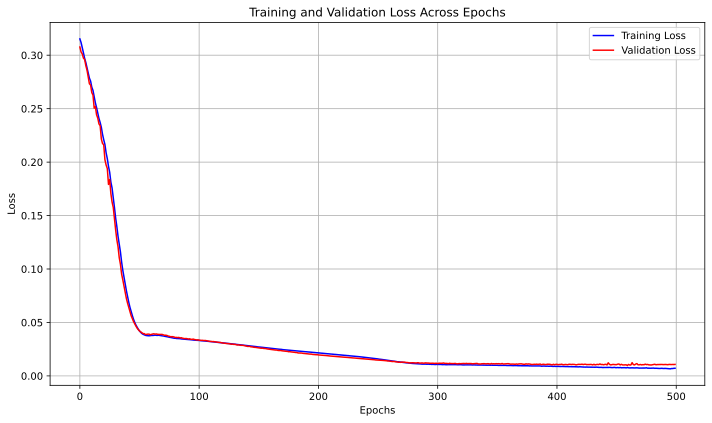

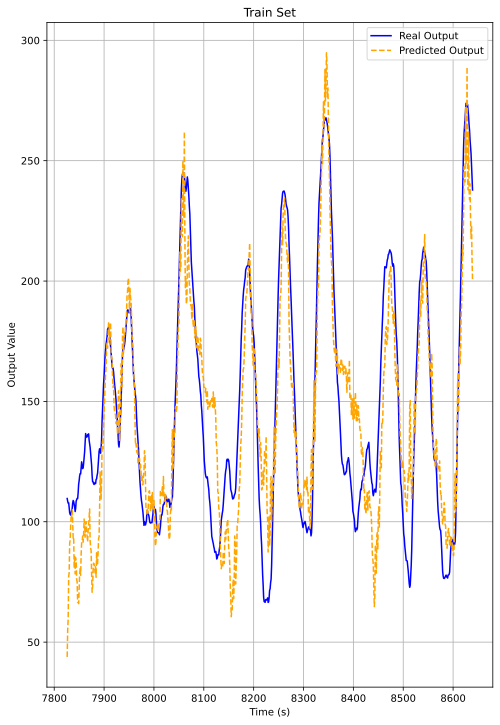

In [12]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

In [14]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.230240 	||	 Validation Loss: 0.228563


Epoch: 2 	||	 Training Loss: 0.230106 	||	 Validation Loss: 0.228427


Epoch: 3 	||	 Training Loss: 0.229975 	||	 Validation Loss: 0.228295


Epoch: 4 	||	 Training Loss: 0.229847 	||	 Validation Loss: 0.228167


Epoch: 5 	||	 Training Loss: 0.229723 	||	 Validation Loss: 0.228041


Epoch: 6 	||	 Training Loss: 0.229601 	||	 Validation Loss: 0.227919


Epoch: 7 	||	 Training Loss: 0.229484 	||	 Validation Loss: 0.227800


Epoch: 8 	||	 Training Loss: 0.229369 	||	 Validation Loss: 0.227684


Epoch: 9 	||	 Training Loss: 0.229257 	||	 Validation Loss: 0.227572


Epoch: 10 	||	 Training Loss: 0.229149 	||	 Validation Loss: 0.227463


Epoch: 11 	||	 Training Loss: 0.229043 	||	 Validation Loss: 0.227356


Epoch: 12 	||	 Training Loss: 0.228941 	||	 Validation Loss: 0.227253


Epoch: 13 	||	 Training Loss: 0.228841 	||	 Validation Loss: 0.227153


Epoch: 14 	||	 Training Loss: 0.228745 	||	 Validation Loss: 0.227055


Epoch: 15 	||	 Training Loss: 0.228651 	||	 Validation Loss: 0.226960


Epoch: 16 	||	 Training Loss: 0.228559 	||	 Validation Loss: 0.226868


Epoch: 17 	||	 Training Loss: 0.228471 	||	 Validation Loss: 0.226779


Epoch: 18 	||	 Training Loss: 0.228385 	||	 Validation Loss: 0.226692


Epoch: 19 	||	 Training Loss: 0.228301 	||	 Validation Loss: 0.226608


Epoch: 20 	||	 Training Loss: 0.228220 	||	 Validation Loss: 0.226526


Epoch: 21 	||	 Training Loss: 0.228141 	||	 Validation Loss: 0.226446


Epoch: 22 	||	 Training Loss: 0.228064 	||	 Validation Loss: 0.226368


Epoch: 23 	||	 Training Loss: 0.227989 	||	 Validation Loss: 0.226293


Epoch: 24 	||	 Training Loss: 0.227917 	||	 Validation Loss: 0.226220


Epoch: 25 	||	 Training Loss: 0.227846 	||	 Validation Loss: 0.226149


Epoch: 26 	||	 Training Loss: 0.227778 	||	 Validation Loss: 0.226080


Epoch: 27 	||	 Training Loss: 0.227711 	||	 Validation Loss: 0.226013


Epoch: 28 	||	 Training Loss: 0.227647 	||	 Validation Loss: 0.225947


Epoch: 29 	||	 Training Loss: 0.227584 	||	 Validation Loss: 0.225884


Epoch: 30 	||	 Training Loss: 0.227523 	||	 Validation Loss: 0.225822


Epoch: 31 	||	 Training Loss: 0.227464 	||	 Validation Loss: 0.225761


Epoch: 32 	||	 Training Loss: 0.227406 	||	 Validation Loss: 0.225703


Epoch: 33 	||	 Training Loss: 0.227350 	||	 Validation Loss: 0.225646


Epoch: 34 	||	 Training Loss: 0.227295 	||	 Validation Loss: 0.225590


Epoch: 35 	||	 Training Loss: 0.227242 	||	 Validation Loss: 0.225536


Epoch: 36 	||	 Training Loss: 0.227190 	||	 Validation Loss: 0.225483


Epoch: 37 	||	 Training Loss: 0.227139 	||	 Validation Loss: 0.225431


Epoch: 38 	||	 Training Loss: 0.227090 	||	 Validation Loss: 0.225381


Epoch: 39 	||	 Training Loss: 0.227042 	||	 Validation Loss: 0.225332


Epoch: 40 	||	 Training Loss: 0.226995 	||	 Validation Loss: 0.225284


Epoch: 41 	||	 Training Loss: 0.226949 	||	 Validation Loss: 0.225237


Epoch: 42 	||	 Training Loss: 0.226905 	||	 Validation Loss: 0.225191


Epoch: 43 	||	 Training Loss: 0.226861 	||	 Validation Loss: 0.225146


Epoch: 44 	||	 Training Loss: 0.226819 	||	 Validation Loss: 0.225103


Epoch: 45 	||	 Training Loss: 0.226778 	||	 Validation Loss: 0.225060


Epoch: 46 	||	 Training Loss: 0.226737 	||	 Validation Loss: 0.225018


Epoch: 47 	||	 Training Loss: 0.226697 	||	 Validation Loss: 0.224977


Epoch: 48 	||	 Training Loss: 0.226659 	||	 Validation Loss: 0.224937


Epoch: 49 	||	 Training Loss: 0.226621 	||	 Validation Loss: 0.224897


Epoch: 50 	||	 Training Loss: 0.226584 	||	 Validation Loss: 0.224859


Epoch: 51 	||	 Training Loss: 0.226547 	||	 Validation Loss: 0.224821


Epoch: 52 	||	 Training Loss: 0.226512 	||	 Validation Loss: 0.224784


Epoch: 53 	||	 Training Loss: 0.226477 	||	 Validation Loss: 0.224748


Epoch: 54 	||	 Training Loss: 0.226443 	||	 Validation Loss: 0.224712


Epoch: 55 	||	 Training Loss: 0.226409 	||	 Validation Loss: 0.224677


Epoch: 56 	||	 Training Loss: 0.226376 	||	 Validation Loss: 0.224642


Epoch: 57 	||	 Training Loss: 0.226344 	||	 Validation Loss: 0.224608


Epoch: 58 	||	 Training Loss: 0.226312 	||	 Validation Loss: 0.224575


Epoch: 59 	||	 Training Loss: 0.226280 	||	 Validation Loss: 0.224542


Epoch: 60 	||	 Training Loss: 0.226249 	||	 Validation Loss: 0.224509


Epoch: 61 	||	 Training Loss: 0.226219 	||	 Validation Loss: 0.224477


Epoch: 62 	||	 Training Loss: 0.226189 	||	 Validation Loss: 0.224445


Epoch: 63 	||	 Training Loss: 0.226159 	||	 Validation Loss: 0.224414


Epoch: 64 	||	 Training Loss: 0.226130 	||	 Validation Loss: 0.224383


Epoch: 65 	||	 Training Loss: 0.226101 	||	 Validation Loss: 0.224353


Epoch: 66 	||	 Training Loss: 0.226073 	||	 Validation Loss: 0.224322


Epoch: 67 	||	 Training Loss: 0.226045 	||	 Validation Loss: 0.224292


Epoch: 68 	||	 Training Loss: 0.226017 	||	 Validation Loss: 0.224263


Epoch: 69 	||	 Training Loss: 0.225989 	||	 Validation Loss: 0.224233


Epoch: 70 	||	 Training Loss: 0.225961 	||	 Validation Loss: 0.224204


Epoch: 71 	||	 Training Loss: 0.225934 	||	 Validation Loss: 0.224175


Epoch: 72 	||	 Training Loss: 0.225907 	||	 Validation Loss: 0.224146


Epoch: 73 	||	 Training Loss: 0.225879 	||	 Validation Loss: 0.224117


Epoch: 74 	||	 Training Loss: 0.225852 	||	 Validation Loss: 0.224088


Epoch: 75 	||	 Training Loss: 0.225825 	||	 Validation Loss: 0.224059


Epoch: 76 	||	 Training Loss: 0.225798 	||	 Validation Loss: 0.224030


Epoch: 77 	||	 Training Loss: 0.225771 	||	 Validation Loss: 0.224001


Epoch: 78 	||	 Training Loss: 0.225744 	||	 Validation Loss: 0.223972


Epoch: 79 	||	 Training Loss: 0.225717 	||	 Validation Loss: 0.223943


Epoch: 80 	||	 Training Loss: 0.225690 	||	 Validation Loss: 0.223913


Epoch: 81 	||	 Training Loss: 0.225662 	||	 Validation Loss: 0.223884


Epoch: 82 	||	 Training Loss: 0.225634 	||	 Validation Loss: 0.223854


Epoch: 83 	||	 Training Loss: 0.225606 	||	 Validation Loss: 0.223824


Epoch: 84 	||	 Training Loss: 0.225578 	||	 Validation Loss: 0.223794


Epoch: 85 	||	 Training Loss: 0.225550 	||	 Validation Loss: 0.223763


Epoch: 86 	||	 Training Loss: 0.225521 	||	 Validation Loss: 0.223732


Epoch: 87 	||	 Training Loss: 0.225491 	||	 Validation Loss: 0.223701


Epoch: 88 	||	 Training Loss: 0.225462 	||	 Validation Loss: 0.223669


Epoch: 89 	||	 Training Loss: 0.225431 	||	 Validation Loss: 0.223636


Epoch: 90 	||	 Training Loss: 0.225401 	||	 Validation Loss: 0.223603


Epoch: 91 	||	 Training Loss: 0.225369 	||	 Validation Loss: 0.223569


Epoch: 92 	||	 Training Loss: 0.225337 	||	 Validation Loss: 0.223534


Epoch: 93 	||	 Training Loss: 0.225304 	||	 Validation Loss: 0.223499


Epoch: 94 	||	 Training Loss: 0.225271 	||	 Validation Loss: 0.223463


Epoch: 95 	||	 Training Loss: 0.225236 	||	 Validation Loss: 0.223426


Epoch: 96 	||	 Training Loss: 0.225201 	||	 Validation Loss: 0.223387


Epoch: 97 	||	 Training Loss: 0.225164 	||	 Validation Loss: 0.223348


Epoch: 98 	||	 Training Loss: 0.225127 	||	 Validation Loss: 0.223307


Epoch: 99 	||	 Training Loss: 0.225088 	||	 Validation Loss: 0.223266


Epoch: 100 	||	 Training Loss: 0.225048 	||	 Validation Loss: 0.223223


Epoch: 101 	||	 Training Loss: 0.225007 	||	 Validation Loss: 0.223178


Epoch: 102 	||	 Training Loss: 0.224964 	||	 Validation Loss: 0.223132


Epoch: 103 	||	 Training Loss: 0.224920 	||	 Validation Loss: 0.223084


Epoch: 104 	||	 Training Loss: 0.224874 	||	 Validation Loss: 0.223035


Epoch: 105 	||	 Training Loss: 0.224826 	||	 Validation Loss: 0.222983


Epoch: 106 	||	 Training Loss: 0.224777 	||	 Validation Loss: 0.222930


Epoch: 107 	||	 Training Loss: 0.224726 	||	 Validation Loss: 0.222875


Epoch: 108 	||	 Training Loss: 0.224672 	||	 Validation Loss: 0.222817


Epoch: 109 	||	 Training Loss: 0.224616 	||	 Validation Loss: 0.222757


Epoch: 110 	||	 Training Loss: 0.224558 	||	 Validation Loss: 0.222694


Epoch: 111 	||	 Training Loss: 0.224498 	||	 Validation Loss: 0.222628


Epoch: 112 	||	 Training Loss: 0.224434 	||	 Validation Loss: 0.222559


Epoch: 113 	||	 Training Loss: 0.224368 	||	 Validation Loss: 0.222488


Epoch: 114 	||	 Training Loss: 0.224298 	||	 Validation Loss: 0.222412


Epoch: 115 	||	 Training Loss: 0.224225 	||	 Validation Loss: 0.222333


Epoch: 116 	||	 Training Loss: 0.224148 	||	 Validation Loss: 0.222250


Epoch: 117 	||	 Training Loss: 0.224068 	||	 Validation Loss: 0.222162


Epoch: 118 	||	 Training Loss: 0.223983 	||	 Validation Loss: 0.222070


Epoch: 119 	||	 Training Loss: 0.223893 	||	 Validation Loss: 0.221973


Epoch: 120 	||	 Training Loss: 0.223798 	||	 Validation Loss: 0.221870


Epoch: 121 	||	 Training Loss: 0.223698 	||	 Validation Loss: 0.221762


Epoch: 122 	||	 Training Loss: 0.223592 	||	 Validation Loss: 0.221646


Epoch: 123 	||	 Training Loss: 0.223479 	||	 Validation Loss: 0.221524


Epoch: 124 	||	 Training Loss: 0.223360 	||	 Validation Loss: 0.221394


Epoch: 125 	||	 Training Loss: 0.223233 	||	 Validation Loss: 0.221256


Epoch: 126 	||	 Training Loss: 0.223098 	||	 Validation Loss: 0.221109


Epoch: 127 	||	 Training Loss: 0.222953 	||	 Validation Loss: 0.220952


Epoch: 128 	||	 Training Loss: 0.222799 	||	 Validation Loss: 0.220784


Epoch: 129 	||	 Training Loss: 0.222634 	||	 Validation Loss: 0.220603


Epoch: 130 	||	 Training Loss: 0.222457 	||	 Validation Loss: 0.220410


Epoch: 131 	||	 Training Loss: 0.222266 	||	 Validation Loss: 0.220202


Epoch: 132 	||	 Training Loss: 0.222061 	||	 Validation Loss: 0.219977


Epoch: 133 	||	 Training Loss: 0.221840 	||	 Validation Loss: 0.219735


Epoch: 134 	||	 Training Loss: 0.221601 	||	 Validation Loss: 0.219472


Epoch: 135 	||	 Training Loss: 0.221341 	||	 Validation Loss: 0.219187


Epoch: 136 	||	 Training Loss: 0.221059 	||	 Validation Loss: 0.218877


Epoch: 137 	||	 Training Loss: 0.220752 	||	 Validation Loss: 0.218539


Epoch: 138 	||	 Training Loss: 0.220416 	||	 Validation Loss: 0.218169


Epoch: 139 	||	 Training Loss: 0.220049 	||	 Validation Loss: 0.217763


Epoch: 140 	||	 Training Loss: 0.219646 	||	 Validation Loss: 0.217317


Epoch: 141 	||	 Training Loss: 0.219203 	||	 Validation Loss: 0.216826


Epoch: 142 	||	 Training Loss: 0.218715 	||	 Validation Loss: 0.216285


Epoch: 143 	||	 Training Loss: 0.218176 	||	 Validation Loss: 0.215686


Epoch: 144 	||	 Training Loss: 0.217579 	||	 Validation Loss: 0.215024


Epoch: 145 	||	 Training Loss: 0.216918 	||	 Validation Loss: 0.214289


Epoch: 146 	||	 Training Loss: 0.216186 	||	 Validation Loss: 0.213474


Epoch: 147 	||	 Training Loss: 0.215372 	||	 Validation Loss: 0.212570


Epoch: 148 	||	 Training Loss: 0.214469 	||	 Validation Loss: 0.211565


Epoch: 149 	||	 Training Loss: 0.213465 	||	 Validation Loss: 0.210449


Epoch: 150 	||	 Training Loss: 0.212349 	||	 Validation Loss: 0.209211


Epoch: 151 	||	 Training Loss: 0.211111 	||	 Validation Loss: 0.207837


Epoch: 152 	||	 Training Loss: 0.209737 	||	 Validation Loss: 0.206316


Epoch: 153 	||	 Training Loss: 0.208215 	||	 Validation Loss: 0.204635


Epoch: 154 	||	 Training Loss: 0.206532 	||	 Validation Loss: 0.202778


Epoch: 155 	||	 Training Loss: 0.204673 	||	 Validation Loss: 0.200731


Epoch: 156 	||	 Training Loss: 0.202623 	||	 Validation Loss: 0.198476


Epoch: 157 	||	 Training Loss: 0.200365 	||	 Validation Loss: 0.195993


Epoch: 158 	||	 Training Loss: 0.197876 	||	 Validation Loss: 0.193259


Epoch: 159 	||	 Training Loss: 0.195135 	||	 Validation Loss: 0.190248


Epoch: 160 	||	 Training Loss: 0.192117 	||	 Validation Loss: 0.186938


Epoch: 161 	||	 Training Loss: 0.188795 	||	 Validation Loss: 0.183305


Epoch: 162 	||	 Training Loss: 0.185148 	||	 Validation Loss: 0.179333


Epoch: 163 	||	 Training Loss: 0.181156 	||	 Validation Loss: 0.175011


Epoch: 164 	||	 Training Loss: 0.176807 	||	 Validation Loss: 0.170334


Epoch: 165 	||	 Training Loss: 0.172093 	||	 Validation Loss: 0.165307


Epoch: 166 	||	 Training Loss: 0.167013 	||	 Validation Loss: 0.159943


Epoch: 167 	||	 Training Loss: 0.161576 	||	 Validation Loss: 0.154266


Epoch: 168 	||	 Training Loss: 0.155799 	||	 Validation Loss: 0.148315


Epoch: 169 	||	 Training Loss: 0.149713 	||	 Validation Loss: 0.142146


Epoch: 170 	||	 Training Loss: 0.143366 	||	 Validation Loss: 0.135837


Epoch: 171 	||	 Training Loss: 0.136829 	||	 Validation Loss: 0.129488


Epoch: 172 	||	 Training Loss: 0.130200 	||	 Validation Loss: 0.123213


Epoch: 173 	||	 Training Loss: 0.123598 	||	 Validation Loss: 0.117133


Epoch: 174 	||	 Training Loss: 0.117153 	||	 Validation Loss: 0.111356


Epoch: 175 	||	 Training Loss: 0.110992 	||	 Validation Loss: 0.105964


Epoch: 176 	||	 Training Loss: 0.105215 	||	 Validation Loss: 0.101012


Epoch: 177 	||	 Training Loss: 0.099894 	||	 Validation Loss: 0.096528


Epoch: 178 	||	 Training Loss: 0.095072 	||	 Validation Loss: 0.092514


Epoch: 179 	||	 Training Loss: 0.090759 	||	 Validation Loss: 0.088944


Epoch: 180 	||	 Training Loss: 0.086932 	||	 Validation Loss: 0.085780


Epoch: 181 	||	 Training Loss: 0.083549 	||	 Validation Loss: 0.082973


Epoch: 182 	||	 Training Loss: 0.080560 	||	 Validation Loss: 0.080477


Epoch: 183 	||	 Training Loss: 0.077912 	||	 Validation Loss: 0.078247


Epoch: 184 	||	 Training Loss: 0.075557 	||	 Validation Loss: 0.076243


Epoch: 185 	||	 Training Loss: 0.073449 	||	 Validation Loss: 0.074423


Epoch: 186 	||	 Training Loss: 0.071543 	||	 Validation Loss: 0.072755


Epoch: 187 	||	 Training Loss: 0.069801 	||	 Validation Loss: 0.071208


Epoch: 188 	||	 Training Loss: 0.068190 	||	 Validation Loss: 0.069758


Epoch: 189 	||	 Training Loss: 0.066684 	||	 Validation Loss: 0.068386


Epoch: 190 	||	 Training Loss: 0.065260 	||	 Validation Loss: 0.067075


Epoch: 191 	||	 Training Loss: 0.063901 	||	 Validation Loss: 0.065811


Epoch: 192 	||	 Training Loss: 0.062590 	||	 Validation Loss: 0.064584


Epoch: 193 	||	 Training Loss: 0.061316 	||	 Validation Loss: 0.063386


Epoch: 194 	||	 Training Loss: 0.060071 	||	 Validation Loss: 0.062214


Epoch: 195 	||	 Training Loss: 0.058851 	||	 Validation Loss: 0.061062


Epoch: 196 	||	 Training Loss: 0.057650 	||	 Validation Loss: 0.059931


Epoch: 197 	||	 Training Loss: 0.056467 	||	 Validation Loss: 0.058818


Epoch: 198 	||	 Training Loss: 0.055301 	||	 Validation Loss: 0.057724


Epoch: 199 	||	 Training Loss: 0.054153 	||	 Validation Loss: 0.056652


Epoch: 200 	||	 Training Loss: 0.053024 	||	 Validation Loss: 0.055603


Epoch: 201 	||	 Training Loss: 0.051918 	||	 Validation Loss: 0.054580


Epoch: 202 	||	 Training Loss: 0.050837 	||	 Validation Loss: 0.053587


Epoch: 203 	||	 Training Loss: 0.049785 	||	 Validation Loss: 0.052626


Epoch: 204 	||	 Training Loss: 0.048765 	||	 Validation Loss: 0.051700


Epoch: 205 	||	 Training Loss: 0.047782 	||	 Validation Loss: 0.050811


Epoch: 206 	||	 Training Loss: 0.046836 	||	 Validation Loss: 0.049962


Epoch: 207 	||	 Training Loss: 0.045932 	||	 Validation Loss: 0.049154


Epoch: 208 	||	 Training Loss: 0.045071 	||	 Validation Loss: 0.048388


Epoch: 209 	||	 Training Loss: 0.044253 	||	 Validation Loss: 0.047664


Epoch: 210 	||	 Training Loss: 0.043480 	||	 Validation Loss: 0.046982


Epoch: 211 	||	 Training Loss: 0.042752 	||	 Validation Loss: 0.046343


Epoch: 212 	||	 Training Loss: 0.042069 	||	 Validation Loss: 0.045745


Epoch: 213 	||	 Training Loss: 0.041430 	||	 Validation Loss: 0.045188


Epoch: 214 	||	 Training Loss: 0.040834 	||	 Validation Loss: 0.044670


Epoch: 215 	||	 Training Loss: 0.040281 	||	 Validation Loss: 0.044191


Epoch: 216 	||	 Training Loss: 0.039768 	||	 Validation Loss: 0.043748


Epoch: 217 	||	 Training Loss: 0.039295 	||	 Validation Loss: 0.043340


Epoch: 218 	||	 Training Loss: 0.038858 	||	 Validation Loss: 0.042965


Epoch: 219 	||	 Training Loss: 0.038458 	||	 Validation Loss: 0.042622


Epoch: 220 	||	 Training Loss: 0.038091 	||	 Validation Loss: 0.042308


Epoch: 221 	||	 Training Loss: 0.037755 	||	 Validation Loss: 0.042023


Epoch: 222 	||	 Training Loss: 0.037449 	||	 Validation Loss: 0.041763


Epoch: 223 	||	 Training Loss: 0.037171 	||	 Validation Loss: 0.041527


Epoch: 224 	||	 Training Loss: 0.036918 	||	 Validation Loss: 0.041314


Epoch: 225 	||	 Training Loss: 0.036689 	||	 Validation Loss: 0.041122


Epoch: 226 	||	 Training Loss: 0.036480 	||	 Validation Loss: 0.040948


Epoch: 227 	||	 Training Loss: 0.036291 	||	 Validation Loss: 0.040790


Epoch: 228 	||	 Training Loss: 0.036118 	||	 Validation Loss: 0.040649


Epoch: 229 	||	 Training Loss: 0.035961 	||	 Validation Loss: 0.040521


Epoch: 230 	||	 Training Loss: 0.035817 	||	 Validation Loss: 0.040405


Epoch: 231 	||	 Training Loss: 0.035683 	||	 Validation Loss: 0.040300


Epoch: 232 	||	 Training Loss: 0.035559 	||	 Validation Loss: 0.040205


Epoch: 233 	||	 Training Loss: 0.035443 	||	 Validation Loss: 0.040119


Epoch: 234 	||	 Training Loss: 0.035334 	||	 Validation Loss: 0.040041


Epoch: 235 	||	 Training Loss: 0.035230 	||	 Validation Loss: 0.039971


Epoch: 236 	||	 Training Loss: 0.035132 	||	 Validation Loss: 0.039909


Epoch: 237 	||	 Training Loss: 0.035039 	||	 Validation Loss: 0.039854


Epoch: 238 	||	 Training Loss: 0.034952 	||	 Validation Loss: 0.039807


Epoch: 239 	||	 Training Loss: 0.034869 	||	 Validation Loss: 0.039765


Epoch: 240 	||	 Training Loss: 0.034793 	||	 Validation Loss: 0.039727


Epoch: 241 	||	 Training Loss: 0.034720 	||	 Validation Loss: 0.039692


Epoch: 242 	||	 Training Loss: 0.034652 	||	 Validation Loss: 0.039656


Epoch: 243 	||	 Training Loss: 0.034586 	||	 Validation Loss: 0.039620


Epoch: 244 	||	 Training Loss: 0.034523 	||	 Validation Loss: 0.039583


Epoch: 245 	||	 Training Loss: 0.034462 	||	 Validation Loss: 0.039546


Epoch: 246 	||	 Training Loss: 0.034403 	||	 Validation Loss: 0.039510


Epoch: 247 	||	 Training Loss: 0.034348 	||	 Validation Loss: 0.039476


Epoch: 248 	||	 Training Loss: 0.034295 	||	 Validation Loss: 0.039446


Epoch: 249 	||	 Training Loss: 0.034246 	||	 Validation Loss: 0.039419


Epoch: 250 	||	 Training Loss: 0.034199 	||	 Validation Loss: 0.039396


Epoch: 251 	||	 Training Loss: 0.034154 	||	 Validation Loss: 0.039377


Epoch: 252 	||	 Training Loss: 0.034110 	||	 Validation Loss: 0.039361


Epoch: 253 	||	 Training Loss: 0.034068 	||	 Validation Loss: 0.039348


Epoch: 254 	||	 Training Loss: 0.034028 	||	 Validation Loss: 0.039338


Epoch: 255 	||	 Training Loss: 0.033989 	||	 Validation Loss: 0.039330


Epoch: 256 	||	 Training Loss: 0.033951 	||	 Validation Loss: 0.039322


Epoch: 257 	||	 Training Loss: 0.033916 	||	 Validation Loss: 0.039313


Epoch: 258 	||	 Training Loss: 0.033882 	||	 Validation Loss: 0.039302


Epoch: 259 	||	 Training Loss: 0.033848 	||	 Validation Loss: 0.039289


Epoch: 260 	||	 Training Loss: 0.033816 	||	 Validation Loss: 0.039274


Epoch: 261 	||	 Training Loss: 0.033784 	||	 Validation Loss: 0.039259


Epoch: 262 	||	 Training Loss: 0.033754 	||	 Validation Loss: 0.039242


Epoch: 263 	||	 Training Loss: 0.033725 	||	 Validation Loss: 0.039227


Epoch: 264 	||	 Training Loss: 0.033696 	||	 Validation Loss: 0.039214


Epoch: 265 	||	 Training Loss: 0.033669 	||	 Validation Loss: 0.039202


Epoch: 266 	||	 Training Loss: 0.033642 	||	 Validation Loss: 0.039194


Epoch: 267 	||	 Training Loss: 0.033615 	||	 Validation Loss: 0.039187


Epoch: 268 	||	 Training Loss: 0.033590 	||	 Validation Loss: 0.039182


Epoch: 269 	||	 Training Loss: 0.033565 	||	 Validation Loss: 0.039178


Epoch: 270 	||	 Training Loss: 0.033541 	||	 Validation Loss: 0.039173


Epoch: 271 	||	 Training Loss: 0.033517 	||	 Validation Loss: 0.039167


Epoch: 272 	||	 Training Loss: 0.033494 	||	 Validation Loss: 0.039160


Epoch: 273 	||	 Training Loss: 0.033472 	||	 Validation Loss: 0.039150


Epoch: 274 	||	 Training Loss: 0.033450 	||	 Validation Loss: 0.039139


Epoch: 275 	||	 Training Loss: 0.033428 	||	 Validation Loss: 0.039127


Epoch: 276 	||	 Training Loss: 0.033407 	||	 Validation Loss: 0.039116


Epoch: 277 	||	 Training Loss: 0.033386 	||	 Validation Loss: 0.039106


Epoch: 278 	||	 Training Loss: 0.033365 	||	 Validation Loss: 0.039097


Epoch: 279 	||	 Training Loss: 0.033345 	||	 Validation Loss: 0.039091


Epoch: 280 	||	 Training Loss: 0.033326 	||	 Validation Loss: 0.039085


Epoch: 281 	||	 Training Loss: 0.033306 	||	 Validation Loss: 0.039081


Epoch: 282 	||	 Training Loss: 0.033287 	||	 Validation Loss: 0.039076


Epoch: 283 	||	 Training Loss: 0.033269 	||	 Validation Loss: 0.039069


Epoch: 284 	||	 Training Loss: 0.033250 	||	 Validation Loss: 0.039061


Epoch: 285 	||	 Training Loss: 0.033232 	||	 Validation Loss: 0.039051


Epoch: 286 	||	 Training Loss: 0.033214 	||	 Validation Loss: 0.039041


Epoch: 287 	||	 Training Loss: 0.033196 	||	 Validation Loss: 0.039031


Epoch: 288 	||	 Training Loss: 0.033179 	||	 Validation Loss: 0.039021


Epoch: 289 	||	 Training Loss: 0.033162 	||	 Validation Loss: 0.039013


Epoch: 290 	||	 Training Loss: 0.033145 	||	 Validation Loss: 0.039006


Epoch: 291 	||	 Training Loss: 0.033128 	||	 Validation Loss: 0.039000


Epoch: 292 	||	 Training Loss: 0.033111 	||	 Validation Loss: 0.038993


Epoch: 293 	||	 Training Loss: 0.033095 	||	 Validation Loss: 0.038986


Epoch: 294 	||	 Training Loss: 0.033078 	||	 Validation Loss: 0.038978


Epoch: 295 	||	 Training Loss: 0.033062 	||	 Validation Loss: 0.038969


Epoch: 296 	||	 Training Loss: 0.033046 	||	 Validation Loss: 0.038958


Epoch: 297 	||	 Training Loss: 0.033031 	||	 Validation Loss: 0.038948


Epoch: 298 	||	 Training Loss: 0.033015 	||	 Validation Loss: 0.038938


Epoch: 299 	||	 Training Loss: 0.032999 	||	 Validation Loss: 0.038930


Epoch: 300 	||	 Training Loss: 0.032984 	||	 Validation Loss: 0.038922


Epoch: 301 	||	 Training Loss: 0.032969 	||	 Validation Loss: 0.038915


Epoch: 302 	||	 Training Loss: 0.032954 	||	 Validation Loss: 0.038907


Epoch: 303 	||	 Training Loss: 0.032938 	||	 Validation Loss: 0.038899


Epoch: 304 	||	 Training Loss: 0.032924 	||	 Validation Loss: 0.038889


Epoch: 305 	||	 Training Loss: 0.032909 	||	 Validation Loss: 0.038878


Epoch: 306 	||	 Training Loss: 0.032894 	||	 Validation Loss: 0.038868


Epoch: 307 	||	 Training Loss: 0.032879 	||	 Validation Loss: 0.038858


Epoch: 308 	||	 Training Loss: 0.032865 	||	 Validation Loss: 0.038849


Epoch: 309 	||	 Training Loss: 0.032851 	||	 Validation Loss: 0.038841


Epoch: 310 	||	 Training Loss: 0.032836 	||	 Validation Loss: 0.038832


Epoch: 311 	||	 Training Loss: 0.032822 	||	 Validation Loss: 0.038824


Epoch: 312 	||	 Training Loss: 0.032808 	||	 Validation Loss: 0.038814


Epoch: 313 	||	 Training Loss: 0.032794 	||	 Validation Loss: 0.038803


Epoch: 314 	||	 Training Loss: 0.032780 	||	 Validation Loss: 0.038793


Epoch: 315 	||	 Training Loss: 0.032766 	||	 Validation Loss: 0.038783


Epoch: 316 	||	 Training Loss: 0.032752 	||	 Validation Loss: 0.038773


Epoch: 317 	||	 Training Loss: 0.032738 	||	 Validation Loss: 0.038764


Epoch: 318 	||	 Training Loss: 0.032725 	||	 Validation Loss: 0.038755


Epoch: 319 	||	 Training Loss: 0.032711 	||	 Validation Loss: 0.038746


Epoch: 320 	||	 Training Loss: 0.032698 	||	 Validation Loss: 0.038736


Epoch: 321 	||	 Training Loss: 0.032684 	||	 Validation Loss: 0.038725


Epoch: 322 	||	 Training Loss: 0.032671 	||	 Validation Loss: 0.038715


Epoch: 323 	||	 Training Loss: 0.032657 	||	 Validation Loss: 0.038705


Epoch: 324 	||	 Training Loss: 0.032644 	||	 Validation Loss: 0.038695


Epoch: 325 	||	 Training Loss: 0.032631 	||	 Validation Loss: 0.038685


Epoch: 326 	||	 Training Loss: 0.032618 	||	 Validation Loss: 0.038676


Epoch: 327 	||	 Training Loss: 0.032605 	||	 Validation Loss: 0.038666


Epoch: 328 	||	 Training Loss: 0.032592 	||	 Validation Loss: 0.038656


Epoch: 329 	||	 Training Loss: 0.032579 	||	 Validation Loss: 0.038645


Epoch: 330 	||	 Training Loss: 0.032566 	||	 Validation Loss: 0.038635


Epoch: 331 	||	 Training Loss: 0.032553 	||	 Validation Loss: 0.038625


Epoch: 332 	||	 Training Loss: 0.032540 	||	 Validation Loss: 0.038616


Epoch: 333 	||	 Training Loss: 0.032527 	||	 Validation Loss: 0.038606


Epoch: 334 	||	 Training Loss: 0.032514 	||	 Validation Loss: 0.038597


Epoch: 335 	||	 Training Loss: 0.032502 	||	 Validation Loss: 0.038586


Epoch: 336 	||	 Training Loss: 0.032489 	||	 Validation Loss: 0.038576


Epoch: 337 	||	 Training Loss: 0.032477 	||	 Validation Loss: 0.038566


Epoch: 338 	||	 Training Loss: 0.032464 	||	 Validation Loss: 0.038556


Epoch: 339 	||	 Training Loss: 0.032452 	||	 Validation Loss: 0.038547


Epoch: 340 	||	 Training Loss: 0.032439 	||	 Validation Loss: 0.038537


Epoch: 341 	||	 Training Loss: 0.032427 	||	 Validation Loss: 0.038527


Epoch: 342 	||	 Training Loss: 0.032415 	||	 Validation Loss: 0.038517


Epoch: 343 	||	 Training Loss: 0.032402 	||	 Validation Loss: 0.038507


Epoch: 344 	||	 Training Loss: 0.032390 	||	 Validation Loss: 0.038497


Epoch: 345 	||	 Training Loss: 0.032378 	||	 Validation Loss: 0.038487


Epoch: 346 	||	 Training Loss: 0.032366 	||	 Validation Loss: 0.038478


Epoch: 347 	||	 Training Loss: 0.032353 	||	 Validation Loss: 0.038469


Epoch: 348 	||	 Training Loss: 0.032341 	||	 Validation Loss: 0.038459


Epoch: 349 	||	 Training Loss: 0.032329 	||	 Validation Loss: 0.038449


Epoch: 350 	||	 Training Loss: 0.032317 	||	 Validation Loss: 0.038439


Epoch: 351 	||	 Training Loss: 0.032305 	||	 Validation Loss: 0.038429


Epoch: 352 	||	 Training Loss: 0.032293 	||	 Validation Loss: 0.038420


Epoch: 353 	||	 Training Loss: 0.032282 	||	 Validation Loss: 0.038411


Epoch: 354 	||	 Training Loss: 0.032270 	||	 Validation Loss: 0.038401


Epoch: 355 	||	 Training Loss: 0.032258 	||	 Validation Loss: 0.038391


Epoch: 356 	||	 Training Loss: 0.032246 	||	 Validation Loss: 0.038382


Epoch: 357 	||	 Training Loss: 0.032234 	||	 Validation Loss: 0.038372


Epoch: 358 	||	 Training Loss: 0.032223 	||	 Validation Loss: 0.038363


Epoch: 359 	||	 Training Loss: 0.032211 	||	 Validation Loss: 0.038354


Epoch: 360 	||	 Training Loss: 0.032199 	||	 Validation Loss: 0.038344


Epoch: 361 	||	 Training Loss: 0.032188 	||	 Validation Loss: 0.038335


Epoch: 362 	||	 Training Loss: 0.032176 	||	 Validation Loss: 0.038325


Epoch: 363 	||	 Training Loss: 0.032165 	||	 Validation Loss: 0.038316


Epoch: 364 	||	 Training Loss: 0.032153 	||	 Validation Loss: 0.038306


Epoch: 365 	||	 Training Loss: 0.032141 	||	 Validation Loss: 0.038297


Epoch: 366 	||	 Training Loss: 0.032130 	||	 Validation Loss: 0.038288


Epoch: 367 	||	 Training Loss: 0.032119 	||	 Validation Loss: 0.038279


Epoch: 368 	||	 Training Loss: 0.032107 	||	 Validation Loss: 0.038269


Epoch: 369 	||	 Training Loss: 0.032096 	||	 Validation Loss: 0.038260


Epoch: 370 	||	 Training Loss: 0.032085 	||	 Validation Loss: 0.038251


Epoch: 371 	||	 Training Loss: 0.032073 	||	 Validation Loss: 0.038242


Epoch: 372 	||	 Training Loss: 0.032062 	||	 Validation Loss: 0.038233


Epoch: 373 	||	 Training Loss: 0.032051 	||	 Validation Loss: 0.038223


Epoch: 374 	||	 Training Loss: 0.032040 	||	 Validation Loss: 0.038214


Epoch: 375 	||	 Training Loss: 0.032028 	||	 Validation Loss: 0.038205


Epoch: 376 	||	 Training Loss: 0.032017 	||	 Validation Loss: 0.038196


Epoch: 377 	||	 Training Loss: 0.032006 	||	 Validation Loss: 0.038187


Epoch: 378 	||	 Training Loss: 0.031995 	||	 Validation Loss: 0.038178


Epoch: 379 	||	 Training Loss: 0.031984 	||	 Validation Loss: 0.038169


Epoch: 380 	||	 Training Loss: 0.031973 	||	 Validation Loss: 0.038159


Epoch: 381 	||	 Training Loss: 0.031962 	||	 Validation Loss: 0.038150


Epoch: 382 	||	 Training Loss: 0.031951 	||	 Validation Loss: 0.038142


Epoch: 383 	||	 Training Loss: 0.031940 	||	 Validation Loss: 0.038133


Epoch: 384 	||	 Training Loss: 0.031929 	||	 Validation Loss: 0.038123


Epoch: 385 	||	 Training Loss: 0.031918 	||	 Validation Loss: 0.038114


Epoch: 386 	||	 Training Loss: 0.031907 	||	 Validation Loss: 0.038105


Epoch: 387 	||	 Training Loss: 0.031896 	||	 Validation Loss: 0.038096


Epoch: 388 	||	 Training Loss: 0.031885 	||	 Validation Loss: 0.038087


Epoch: 389 	||	 Training Loss: 0.031874 	||	 Validation Loss: 0.038079


Epoch: 390 	||	 Training Loss: 0.031864 	||	 Validation Loss: 0.038070


Epoch: 391 	||	 Training Loss: 0.031853 	||	 Validation Loss: 0.038061


Epoch: 392 	||	 Training Loss: 0.031842 	||	 Validation Loss: 0.038052


Epoch: 393 	||	 Training Loss: 0.031831 	||	 Validation Loss: 0.038043


Epoch: 394 	||	 Training Loss: 0.031821 	||	 Validation Loss: 0.038034


Epoch: 395 	||	 Training Loss: 0.031810 	||	 Validation Loss: 0.038025


Epoch: 396 	||	 Training Loss: 0.031799 	||	 Validation Loss: 0.038016


Epoch: 397 	||	 Training Loss: 0.031789 	||	 Validation Loss: 0.038007


Epoch: 398 	||	 Training Loss: 0.031778 	||	 Validation Loss: 0.037998


Epoch: 399 	||	 Training Loss: 0.031767 	||	 Validation Loss: 0.037990


Epoch: 400 	||	 Training Loss: 0.031757 	||	 Validation Loss: 0.037981


Epoch: 401 	||	 Training Loss: 0.031746 	||	 Validation Loss: 0.037972


Epoch: 402 	||	 Training Loss: 0.031736 	||	 Validation Loss: 0.037963


Epoch: 403 	||	 Training Loss: 0.031725 	||	 Validation Loss: 0.037954


Epoch: 404 	||	 Training Loss: 0.031715 	||	 Validation Loss: 0.037945


Epoch: 405 	||	 Training Loss: 0.031704 	||	 Validation Loss: 0.037937


Epoch: 406 	||	 Training Loss: 0.031694 	||	 Validation Loss: 0.037928


Epoch: 407 	||	 Training Loss: 0.031683 	||	 Validation Loss: 0.037919


Epoch: 408 	||	 Training Loss: 0.031673 	||	 Validation Loss: 0.037910


Epoch: 409 	||	 Training Loss: 0.031663 	||	 Validation Loss: 0.037902


Epoch: 410 	||	 Training Loss: 0.031652 	||	 Validation Loss: 0.037893


Epoch: 411 	||	 Training Loss: 0.031642 	||	 Validation Loss: 0.037884


Epoch: 412 	||	 Training Loss: 0.031632 	||	 Validation Loss: 0.037875


Epoch: 413 	||	 Training Loss: 0.031621 	||	 Validation Loss: 0.037867


Epoch: 414 	||	 Training Loss: 0.031611 	||	 Validation Loss: 0.037858


Epoch: 415 	||	 Training Loss: 0.031601 	||	 Validation Loss: 0.037850


Epoch: 416 	||	 Training Loss: 0.031590 	||	 Validation Loss: 0.037841


Epoch: 417 	||	 Training Loss: 0.031580 	||	 Validation Loss: 0.037832


Epoch: 418 	||	 Training Loss: 0.031570 	||	 Validation Loss: 0.037823


Epoch: 419 	||	 Training Loss: 0.031560 	||	 Validation Loss: 0.037815


Epoch: 420 	||	 Training Loss: 0.031549 	||	 Validation Loss: 0.037806


Epoch: 421 	||	 Training Loss: 0.031539 	||	 Validation Loss: 0.037797


Epoch: 422 	||	 Training Loss: 0.031529 	||	 Validation Loss: 0.037789


Epoch: 423 	||	 Training Loss: 0.031519 	||	 Validation Loss: 0.037780


Epoch: 424 	||	 Training Loss: 0.031509 	||	 Validation Loss: 0.037772


Epoch: 425 	||	 Training Loss: 0.031499 	||	 Validation Loss: 0.037763


Epoch: 426 	||	 Training Loss: 0.031489 	||	 Validation Loss: 0.037754


Epoch: 427 	||	 Training Loss: 0.031479 	||	 Validation Loss: 0.037746


Epoch: 428 	||	 Training Loss: 0.031469 	||	 Validation Loss: 0.037737


Epoch: 429 	||	 Training Loss: 0.031458 	||	 Validation Loss: 0.037729


Epoch: 430 	||	 Training Loss: 0.031448 	||	 Validation Loss: 0.037720


Epoch: 431 	||	 Training Loss: 0.031438 	||	 Validation Loss: 0.037711


Epoch: 432 	||	 Training Loss: 0.031428 	||	 Validation Loss: 0.037703


Epoch: 433 	||	 Training Loss: 0.031418 	||	 Validation Loss: 0.037695


Epoch: 434 	||	 Training Loss: 0.031409 	||	 Validation Loss: 0.037686


Epoch: 435 	||	 Training Loss: 0.031399 	||	 Validation Loss: 0.037677


Epoch: 436 	||	 Training Loss: 0.031389 	||	 Validation Loss: 0.037669


Epoch: 437 	||	 Training Loss: 0.031379 	||	 Validation Loss: 0.037661


Epoch: 438 	||	 Training Loss: 0.031369 	||	 Validation Loss: 0.037652


Epoch: 439 	||	 Training Loss: 0.031359 	||	 Validation Loss: 0.037643


Epoch: 440 	||	 Training Loss: 0.031349 	||	 Validation Loss: 0.037635


Epoch: 441 	||	 Training Loss: 0.031339 	||	 Validation Loss: 0.037626


Epoch: 442 	||	 Training Loss: 0.031329 	||	 Validation Loss: 0.037618


Epoch: 443 	||	 Training Loss: 0.031319 	||	 Validation Loss: 0.037609


Epoch: 444 	||	 Training Loss: 0.031310 	||	 Validation Loss: 0.037601


Epoch: 445 	||	 Training Loss: 0.031300 	||	 Validation Loss: 0.037593


Epoch: 446 	||	 Training Loss: 0.031290 	||	 Validation Loss: 0.037584


Epoch: 447 	||	 Training Loss: 0.031280 	||	 Validation Loss: 0.037576


Epoch: 448 	||	 Training Loss: 0.031271 	||	 Validation Loss: 0.037567


Epoch: 449 	||	 Training Loss: 0.031261 	||	 Validation Loss: 0.037559


Epoch: 450 	||	 Training Loss: 0.031251 	||	 Validation Loss: 0.037550


Epoch: 451 	||	 Training Loss: 0.031241 	||	 Validation Loss: 0.037542


Epoch: 452 	||	 Training Loss: 0.031232 	||	 Validation Loss: 0.037534


Epoch: 453 	||	 Training Loss: 0.031222 	||	 Validation Loss: 0.037525


Epoch: 454 	||	 Training Loss: 0.031212 	||	 Validation Loss: 0.037517


Epoch: 455 	||	 Training Loss: 0.031203 	||	 Validation Loss: 0.037508


Epoch: 456 	||	 Training Loss: 0.031193 	||	 Validation Loss: 0.037500


Epoch: 457 	||	 Training Loss: 0.031183 	||	 Validation Loss: 0.037491


Epoch: 458 	||	 Training Loss: 0.031174 	||	 Validation Loss: 0.037483


Epoch: 459 	||	 Training Loss: 0.031164 	||	 Validation Loss: 0.037475


Epoch: 460 	||	 Training Loss: 0.031154 	||	 Validation Loss: 0.037466


Epoch: 461 	||	 Training Loss: 0.031145 	||	 Validation Loss: 0.037458


Epoch: 462 	||	 Training Loss: 0.031135 	||	 Validation Loss: 0.037450


Epoch: 463 	||	 Training Loss: 0.031126 	||	 Validation Loss: 0.037441


Epoch: 464 	||	 Training Loss: 0.031116 	||	 Validation Loss: 0.037433


Epoch: 465 	||	 Training Loss: 0.031106 	||	 Validation Loss: 0.037425


Epoch: 466 	||	 Training Loss: 0.031097 	||	 Validation Loss: 0.037416


Epoch: 467 	||	 Training Loss: 0.031087 	||	 Validation Loss: 0.037408


Epoch: 468 	||	 Training Loss: 0.031078 	||	 Validation Loss: 0.037400


Epoch: 469 	||	 Training Loss: 0.031068 	||	 Validation Loss: 0.037391


Epoch: 470 	||	 Training Loss: 0.031059 	||	 Validation Loss: 0.037383


Epoch: 471 	||	 Training Loss: 0.031049 	||	 Validation Loss: 0.037375


Epoch: 472 	||	 Training Loss: 0.031040 	||	 Validation Loss: 0.037367


Epoch: 473 	||	 Training Loss: 0.031030 	||	 Validation Loss: 0.037358


Epoch: 474 	||	 Training Loss: 0.031021 	||	 Validation Loss: 0.037350


Epoch: 475 	||	 Training Loss: 0.031011 	||	 Validation Loss: 0.037341


Epoch: 476 	||	 Training Loss: 0.031002 	||	 Validation Loss: 0.037333


Epoch: 477 	||	 Training Loss: 0.030992 	||	 Validation Loss: 0.037325


Epoch: 478 	||	 Training Loss: 0.030983 	||	 Validation Loss: 0.037317


Epoch: 479 	||	 Training Loss: 0.030974 	||	 Validation Loss: 0.037308


Epoch: 480 	||	 Training Loss: 0.030964 	||	 Validation Loss: 0.037300


Epoch: 481 	||	 Training Loss: 0.030955 	||	 Validation Loss: 0.037292


Epoch: 482 	||	 Training Loss: 0.030945 	||	 Validation Loss: 0.037283


Epoch: 483 	||	 Training Loss: 0.030936 	||	 Validation Loss: 0.037275


Epoch: 484 	||	 Training Loss: 0.030927 	||	 Validation Loss: 0.037267


Epoch: 485 	||	 Training Loss: 0.030917 	||	 Validation Loss: 0.037258


Epoch: 486 	||	 Training Loss: 0.030908 	||	 Validation Loss: 0.037250


Epoch: 487 	||	 Training Loss: 0.030899 	||	 Validation Loss: 0.037242


Epoch: 488 	||	 Training Loss: 0.030889 	||	 Validation Loss: 0.037234


Epoch: 489 	||	 Training Loss: 0.030880 	||	 Validation Loss: 0.037225


Epoch: 490 	||	 Training Loss: 0.030871 	||	 Validation Loss: 0.037217


Epoch: 491 	||	 Training Loss: 0.030861 	||	 Validation Loss: 0.037209


Epoch: 492 	||	 Training Loss: 0.030852 	||	 Validation Loss: 0.037201


Epoch: 493 	||	 Training Loss: 0.030843 	||	 Validation Loss: 0.037192


Epoch: 494 	||	 Training Loss: 0.030833 	||	 Validation Loss: 0.037184


Epoch: 495 	||	 Training Loss: 0.030824 	||	 Validation Loss: 0.037176


Epoch: 496 	||	 Training Loss: 0.030815 	||	 Validation Loss: 0.037167


Epoch: 497 	||	 Training Loss: 0.030806 	||	 Validation Loss: 0.037159


Epoch: 498 	||	 Training Loss: 0.030796 	||	 Validation Loss: 0.037151


Epoch: 499 	||	 Training Loss: 0.030787 	||	 Validation Loss: 0.037142


Epoch: 500 	||	 Training Loss: 0.030778 	||	 Validation Loss: 0.037135


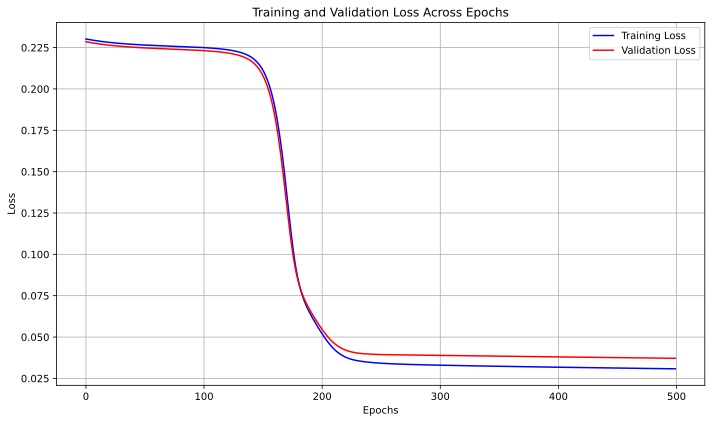

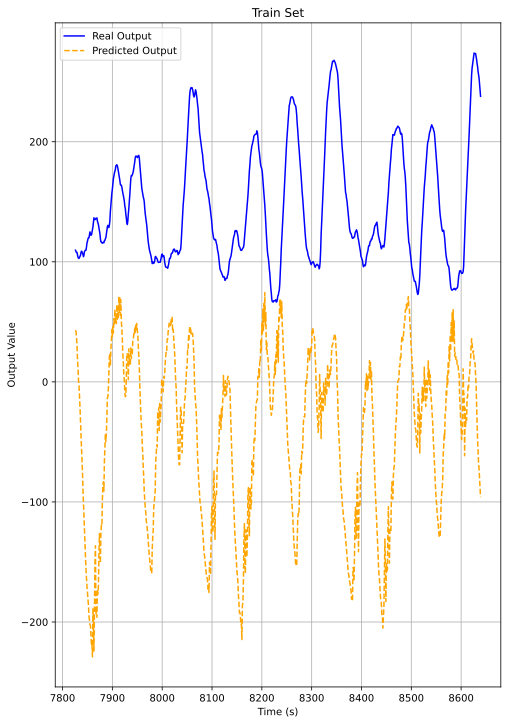

In [15]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()